# Robust yield prediction of various farm processing units

In [ ]:
# Problem_Description

# A new fast food chain is seeing rapid expansion over the past couple of years.
# They are now trying to optimize their supply chain to ensure that there are no shortages of ingredients.

# In this competition you are expected to build a machine learning model(s) that 
## could predict the output of the food processing farms for the next year.

# In this hackathon, we are expected to: 
# 1. Explore the data and engineer new features
# 2. Predict the yield for each farm during the given timestamps
# 3. Given the forecasted demand for the next few months for a particular ingredient, device a strategy to source it.

In [ ]:
# load the different datasets given
# Given data

# Train
# train_dataset         - (date,farm_id,ingrident_type,yield) columns
# train_weather_dataset - (timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed) 

# Test
# test_dataset          - (date,farm_id,ingrident_type,id) columns
# test_weather_dataset  - (timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed)

# Farm
# farm_dataset          - (farm_id,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location) columns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Understanding:

In [ ]:
# ‘train_data.csv’:

# date: The timestamp at which the yield of the food processing farm.
        # the time stamps are for every one hour without any missing values.
    
# farm_id: The farm identifier that recognizes the farm food processing plant.
        # different farms had a farm_id to recognize it.
        # there are a total of 1434 farms in train_data.
        
# ingredient_type: The type of ingredient being produced.
        # there are four different types of ingridents are there.
        # every farm produces every ingredient or few ingredient's individually
        # one farm can produce only one ingrident or two ingridents or three or four ingridents.
        
# yield: The yield of the plant in tonnes.
       # Yield refers to amount of crop produced per unit area of land typically expressed as weight or volumne.

# ‘farm_data.csv’:

# farm_id: The farm identifier that recognizes the farm food processing plant
          # In farm data there are 1449 records about the farm's
          # but in train data we can only see 1434 farm's
          # it says 1449-1434=15 
          # 15 farms have same farm_id but there are under different locations or different companies.
          # so there is need of change in farm_id's.
            
#  founding_year: They year when the operations commenced on the farm and food processing plant. 
#  num_processing_plants: The number of processing plants present on the farm
#  farm_area: The area of the farm in square meters
#  farming_company: The company that owns the farms
#  deidentified_location: The location at which the farm is present

# ● ‘train_weather.csv’:

# For each location where the farms are present, the weather data is also provided by timestamp

# same as for test -- test_data and test weather was given.

#### Reading the Data 

In [ ]:
import pandas as pd
train_dataset=pd.read_csv("/kaggle/input/hackathon-datasets/train_data.csv")
farm_dataset=pd.read_csv("/kaggle/input/hackathon-datasets/farm_data-1646897931981.csv")
weather_dataset=pd.read_csv("/kaggle/input/hackathon-datasets/train_weather-1646897968670.csv")

In [ ]:
print(train_dataset.shape)
print(farm_dataset.shape)
print(weather_dataset.shape)

(20216100, 4)
(1449, 6)
(139773, 9)


In [ ]:
print(train_dataset.columns)
print(farm_dataset.columns)
print(weather_dataset.columns)

Index(['date', 'farm_id', 'ingredient_type', 'yield'], dtype='object')
Index(['farm_id', 'operations_commencing_year', 'num_processing_plants',
       'farm_area', 'farming_company', 'deidentified_location'],
      dtype='object')
Index(['timestamp', 'deidentified_location', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed'],
      dtype='object')


### Merging
#### Merge the given train_dataset, farm_dataset, weather_dataset.

In [ ]:
# how to merge?
# Merging can be done with the help of common columns

# for train_data and farm_data farm_id is the common column
# for train_data and weather_data Timestamp is the common column

# for farm_data and weather_data deidentified location is the common column

#   tarin_data              farm_data              weather_data

#   farm_id                  farm_id                    x
#   Timestamp                   x                  Timestamp
#       x              deidentified location      deidentified location


# here train data is the main dataset and farm_data and weather_data are the supporting data.

# so we can merge the fram_data to train_data with the help of farm_id.

# we cannot merge the weather data with train data just with the time stamp.
# because weather chages from one location to another location
# and different farms are there in different locations.

# after merging the farm_data to train_data we can merge the weather data based on the farm_id and deidentified location.

In [ ]:
# So lets merge the train_data and farm_data

# as we know that farm_data has 1449 farms and train_data has 1434 farms it says 15 farms have same names.
# but those 15 are having same numbers but present in different locations or different companies.
# but in train data there are no location or company data
# so it is difficult to identify and merge them

# for this dropping the repeated farm_id names might be the solution.
# or
# dropping the second repeated farm_id by assuming the there are given in an order in both farm data and train data.


In [ ]:
print(train_dataset.farm_id.nunique())
print(len(farm_dataset.farm_id))

1434
1449


In [ ]:
# dropping the second repeated farm_ids.

farm_dataset_no_duplicates=farm_dataset.drop_duplicates(subset=['farm_id'],keep='first',ignore_index=True)
# all the second repeated values in the farm data is removed

In [ ]:
len(farm_dataset_no_duplicates)

1434

In [ ]:
# Technique 1: Free Memory using gc.collect()¶
import gc
del farm_dataset # it deletes the variable
gc.collect() # it deletes all the residual present in the ram about the dataframe

118

In [ ]:
# in our farm data there are also same farm_id names
# which we are assuming second occured values.

# we simply drop duplicates in farm_data using farm_id.

# but in train_data if we use farm_id we may loose first occured values too.
# so when the farm_id with same time stamp we will drop that.
# but this may leads to loose the first occured values when they are producing the different ingridents.
# so if the data had same farm_id and producing the same_ingrident, producing at same time.

train_dataset_no_duplicates=train_dataset.drop_duplicates(subset=['date','farm_id','ingredient_type'],keep='first',ignore_index=True)

In [ ]:
del train_dataset # it deletes the variable
gc.collect() # it deletes all the residual present in the ram about the dataframe

46

In [ ]:
# Merging
# train_data and farm_data.

train_farm_dataset=pd.merge(train_dataset_no_duplicates,farm_dataset_no_duplicates,on='farm_id',how='left')

In [ ]:
print(train_dataset_no_duplicates.shape)
print(farm_dataset_no_duplicates.shape)
print(train_farm_dataset.shape)

(20080532, 4)
(1434, 6)
(20080532, 9)


In [ ]:
train_farm_dataset.rename(columns={'date':'timestamp'},inplace=True)

In [ ]:
# Merging
# train_farm_dataset and weather dataset.
dataset=pd.merge(train_farm_dataset,weather_dataset,on=['timestamp','deidentified_location'],how='left')

In [ ]:
print(train_farm_dataset.shape)
print(dataset.shape)
# merged successfully

(20080532, 9)
(20080532, 16)


In [ ]:

del train_dataset_no_duplicates
del farm_dataset_no_duplicates
del train_farm_dataset # it deletes the variable
del weather_dataset # it deletes the variable
gc.collect() # it deletes all the residual present in the ram about the dataframe

46

In [ ]:
dataset.columns

Index(['timestamp', 'farm_id', 'ingredient_type', 'yield',
       'operations_commencing_year', 'num_processing_plants', 'farm_area',
       'farming_company', 'deidentified_location', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed'],
      dtype='object')

In [ ]:
# we have our final dataset

# now we can start model building.

# but the data is combined of different farm's, producing different ingridents.

# each farm produces different set of ingridents. 
# some farm will produce one type of yield.
# some farm will produce two types of yileds
# some famrs will produce three types of yields.
# some farms will produce all four types of yields.

# to predict using all the dataset is not possible for time series models
# to predict based on the farm id is not good as there are different ingridents.

# so the data has to be divide into four categories
# ing_w_dataset- farms which producing the ing_w_dataset will be here.
# same as x,y,z.

# for every farm under the different ingrident data the model building will be done.

In [ ]:
# we ned to subset the data based on the ingrident and then with the farm id and build a model
# and have to store their coefficients.

# to store  1434*4=5736  will be very complex

# so lets say we have to extract the data every time and at the end the model coefficients have to be stored in a dataframe

# thats the approach.

# so using those coefficients we have to predict the test?


In [ ]:
# ingrident datasets.

In [ ]:
ing_w_dataset=dataset[dataset['ingredient_type']=='ing_w']
ing_x_dataset=dataset[dataset['ingredient_type']=='ing_x']
ing_y_dataset=dataset[dataset['ingredient_type']=='ing_y']
ing_z_dataset=dataset[dataset['ingredient_type']=='ing_z']

In [ ]:
print(dataset.shape)
print(ing_w_dataset.shape)
print(ing_x_dataset.shape)
print(ing_y_dataset.shape)
print(ing_z_dataset.shape)

(20080532, 16)
(11939301, 16)
(4168481, 16)
(2708713, 16)
(1264037, 16)


In [ ]:
(11939301+4168481+2708713+1264037)

20080532

In [ ]:
# farm_dataset's
# to divide 5736 datasets is complex 
# so let's perform only on one farm 

# randomly choosing the farm as 77519 from ing_w_dataset

In [ ]:
ing_w_farm_id_77519=ing_w_dataset[ing_w_dataset['farm_id']=='fid_77519']

In [ ]:
ing_w_farm_id_77519.head()

timestamp    farm_id ingredient_type    yield  \
1970   2016-01-01 00:00:00  fid_77519           ing_w  142.322   
4248   2016-01-01 01:00:00  fid_77519           ing_w  140.726   
6532   2016-01-01 02:00:00  fid_77519           ing_w  151.223   
8813   2016-01-01 03:00:00  fid_77519           ing_w  142.567   
11094  2016-01-01 04:00:00  fid_77519           ing_w  140.061   

       operations_commencing_year  num_processing_plants     farm_area  \
1970                          NaN                    NaN  10746.647428   
4248                          NaN                    NaN  10746.647428   
6532                          NaN                    NaN  10746.647428   
8813                          NaN                    NaN  10746.647428   
11094                         NaN                    NaN  10746.647428   

      farming_company deidentified_location  temp_obs  cloudiness  \
1970      Wayne Farms         location 5410       NaN         NaN   
4248      Wayne Farms         location 5410       5.6         0.0   
6532      Wayne Farms         location 5410       5.6         4.0   
8813      Wayne Farms         location 5410       5.6         NaN   
11094     Wayne Farms         location 5410       5.0         NaN   

       wind_direction  dew_temp  pressure_sea_level  precipitation  wind_speed  
1970              NaN       NaN                 NaN            NaN         NaN  
4248            300.0      -0.6              1019.3            0.0         2.6  
6532            300.0      -0.6              1019.4            0.0         2.6  
8813              NaN      -1.1              1019.4            0.0         1.5  
11094           290.0      -2.2              1019.2            0.0         3.1

In [ ]:
ing_w_farm_id_77519.shape # 8784 rows and 16 columns # for a leap year there are 8784 hours.shape # 8784 rows and 18 columns # for a leap year there are 8784 hours

(8784, 16)

### Exploratory Data Analysis and Data Preprocessing.

##### Steps

##### step  1 : Type casting.
##### step  2 : Removing wnwanted columns.
##### step  3 : Check weather the time is sorted or not if not sorted sort the data.
##### step  4 : Check if the timestamp has no duplicates if there are any drop the duplicates.
##### step  5 : Check weather the timestamp is continuous or not if not make it continuous.
##### step  6 : Descriptive statistics
##### step  7 : Handle the missing values using Interpolation.
##### step  8 : Handling skwness using transformation technique.
##### step  9 : Correlation between the features.
##### step 10 : Extracting features from time stamp.
##### step 11 : Conversion of time stamp to index.
##### step 12 : Data Decomposition.
##### step 13 : Split the data manually using time seq.

##### End of Data Preprocessing.
##### ---------------------------------------------------------

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Step1: Type Casting

In [ ]:
ing_w_farm_id_77519.dtypes # data can be in any data type # type conversion can help in many ways

timestamp                      object
farm_id                        object
ingredient_type                object
yield                         float64
operations_commencing_year    float64
num_processing_plants         float64
farm_area                     float64
farming_company                object
deidentified_location          object
temp_obs                      float64
cloudiness                    float64
wind_direction                float64
dew_temp                      float64
pressure_sea_level            float64
precipitation                 float64
wind_speed                    float64
dtype: object

In [ ]:
# timestamp is date_time data type
ing_w_farm_id_77519['timestamp']=pd.to_datetime(ing_w_farm_id_77519['timestamp'],format='%Y-%m-%d %H:%M:%S')
ing_w_farm_id_77519.timestamp.dtype

dtype('<M8[ns]')

### step 2 : Removing Unwanted columns

In [ ]:
# this data is all about one farm and one type of ingrident
# so farm_id, ingridnet_type,operations_commencing_year,num_processing_plants,farm_area,farming_company,
## deidentified_location are unique for whole data
# so these columns can be dropped as they are unique.
ing_w_farm_id_77519.drop(['farm_id', 'ingredient_type',
       'operations_commencing_year', 'num_processing_plants', 'farm_area',
       'farming_company', 'deidentified_location'],axis=1,inplace=True)

In [ ]:
numerical_variables=ing_w_farm_id_77519.describe().columns
[print(x ,ing_w_farm_id_77519[x].max(),ing_w_farm_id_77519[x].dtype) for x in numerical_variables]

yield 254.229 float64
temp_obs 35.6 float64
cloudiness 9.0 float64
wind_direction 360.0 float64
dew_temp 25.6 float64
pressure_sea_level 1040.3 float64
precipitation 150.0 float64
wind_speed 13.4 float64


[None, None, None, None, None, None, None, None]

In [ ]:
# 'temp_obs', 'cloudiness','wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation','wind_speed','yield' are using 8 bytes of memory
# which can also store in float32 which will only use 4 bytes of memory.

for i in numerical_variables:
    ing_w_farm_id_77519[i]=ing_w_farm_id_77519[i].astype("float32")
## type conversion and removing of unwanted columns are done.

### Step 3: check weather timestamp is sorted

In [ ]:
ing_w_farm_id_77519.timestamp.is_monotonic

True

### Step 4: check weather timestamp has no  duplicates

In [ ]:
print(ing_w_farm_id_77519.timestamp.duplicated().any())

False


In [ ]:
# print(ing_w_farm_id_77519.timestamp.duplicated().sum()) # thanks to nandhini.

#### Step 5: check weather the timestamp is in continuous order

In [ ]:

# as we know that it is a year data

# lets create a new dataframe with the help of this min and maximun values

sequential_date_hour = pd.DataFrame(pd.date_range(min(ing_w_farm_id_77519.timestamp),max(ing_w_farm_id_77519.timestamp),freq='H'),columns=['Date'])



# now all we have to do is merge them

seq_data = pd.merge(sequential_date_hour,ing_w_farm_id_77519,how='outer',left_on=['Date'],right_on=['timestamp'],sort=True)



# if there any discontinues dates then length of the both dataframes would be different.

# and there could be missing values in our timestamp.

# lets ensure that if there are missing values or not.

print(seq_data.timestamp.isna().sum())

# the len of the both dataframes is same so we can ensure that there are no missing dates in the data





# as there are two dates now as both are same we can drop one of them

# incase if there are any missing values in the dates then we must drop the our time stamp and have to work with nee date column

# so lets drop our time stamp

seq_data.drop('Date',axis=1,inplace=True)

0


In [ ]:
del seq_data

### Step 6: Descriptive Statistics

In [ ]:
ing_w_farm_id_77519.describe()

yield     temp_obs   cloudiness  wind_direction     dew_temp  \
count  8784.000000  8776.000000  5466.000000     8487.000000  8776.000000   
mean    153.676910    13.258410     0.562203      187.723816     5.775160   
std      53.201488    10.254210     1.480298      122.693604    10.606409   
min       0.000000   -15.600000     0.000000        0.000000   -25.600000   
25%     141.306000     5.000000     0.000000       70.000000    -2.800000   
50%     153.538994    13.300000     0.000000      210.000000     6.100000   
75%     185.169746    21.700001     0.000000      300.000000    15.000000   
max     254.229004    35.599998     9.000000      360.000000    25.600000   

       pressure_sea_level  precipitation   wind_speed  
count         8667.000000    8746.000000  8754.000000  
mean          1016.377991       0.742740     3.076776  
std              7.251592       5.661837     2.073463  
min            989.599976      -1.000000     0.000000  
25%           1011.700012       0.000000     1.500000  
50%           1016.500000       0.000000     2.600000  
75%           1021.000000       0.000000     4.100000  
max           1040.300049     150.000000    13.400000

In [ ]:
# train_data.describe().round(2) # ?? from nandhini

# checking misiing value count for test weather data
# test_weather.isna().mean().round(4) * 100

### Step 7: Handling Null Values

<AxesSubplot:>

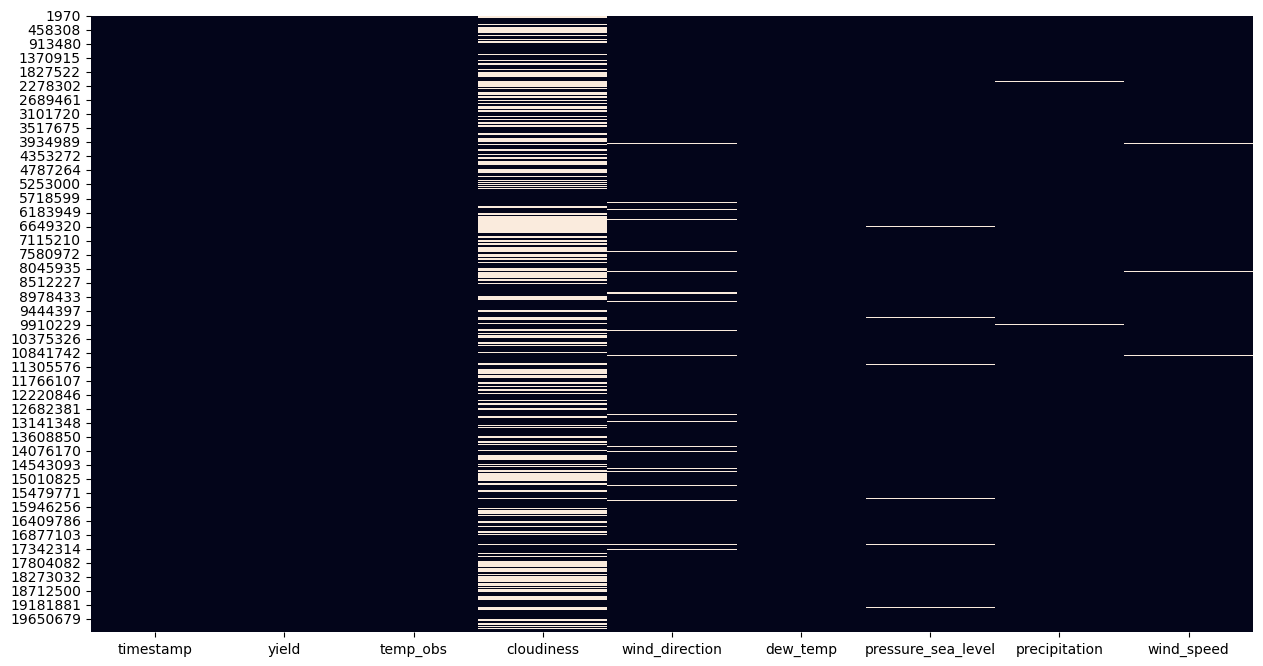

In [ ]:
# Null values
# temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed has null values

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
sns.heatmap(ing_w_farm_id_77519.isna(),cbar=False)

In [ ]:
# lets fill the null values
# before filling the null values make sure weather the data is in continuous and no duplicates.
# as our data is in continous format and no duplicates we can fill the null values using interpolate method.

In [ ]:
# Interpolate :

# it is a technique which is used to fill the null values based on the neighbours

# when we use the interpolation method is 

# if the data is not appropriate to fill the missing values with the help of mean or median or mode

# so in that case we use the interpolation
 
# as interpolate method can only works for numerical data 
numerical_columns=ing_w_farm_id_77519.describe().columns
[ing_w_farm_id_77519[x].interpolate(method='linear',limit_direction="both",inplace=True) for x in numerical_columns]

[None, None, None, None, None, None, None, None]

### Step 8: Handling skwness

In [ ]:
import seaborn as sns
import statistics as s
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
def dist_nor_plot(a):
    plt.figure(figsize=(10,6))
    sns.distplot(a)                                                               # dist plot
    plt.axvline(x=s.mean(a),color='red',label='mean')                             # mean
    plt.axvline(x=s.median(a),color='black',label='median')                       # median
    plt.axvline(x=s.mode(a),color='green',label='mode')                           # mode
    plt.axvline(x=np.quantile(a,0.25),color='blue',ls='--',label='q1')            # q1 
    plt.axvline(x=np.quantile(a,0.5),color='blue',ls='--',label='q2')             # q2
    plt.axvline(x=np.quantile(a,0.75),color='blue',ls='--',label='q3')            # q3
    plt.axvline(x=np.quantile(a,1),color='blue',ls='--',label='q4')               # q4
    iqr=(np.quantile(a,0.75)-np.quantile(a,0.25))                                 # lower whishker
    plt.axvline(x=(np.quantile(a,0.25)-1.5*iqr),color='black',ls='--',label='UW') # upper whishker
    plt.axvline(x=(np.quantile(a,0.75)+1.5*iqr),color='black',ls='--',label='LW') # upper whishker
    
    # empherical formula
    # data b/w u-1sd and u+1sd then 68% data is in between them
    # same as data b/w u-2sd to u+2d then 95% data is in between them
    # same as data b/w u-3d to u+3sd the 99.7% data is in between them
    # so standard deviation s.stdev(df['target'])
    plt.axvline(x=(np.mean(a)-3*(s.stdev(a))),color='pink',ls='--',label='99.7%') # 99.7% data
    plt.axvline(x=(np.mean(a)+3*(s.stdev(a))),color='pink',ls='--')
        
    print("mean:",a.mean())
    print("median:",a.median())
    print("mode:",s.mode(a))
    print("skewness:",skew(a))
    print("q1:",np.quantile(a,0.25))
    print("q2:",np.quantile(a,0.5))
    print("q3:",np.quantile(a,0.75))
    print("q4:",np.quantile(a,0.1))
    print("lower whishker:",(np.quantile(a,0.25)-1.5*iqr))
    print("upper whishker:",(np.quantile(a,0.75)+1.5*iqr))
    plt.legend(loc='best')
    #sns.boxplot(a)
    

In [ ]:
ing_w_farm_id_77519.columns

Index(['timestamp', 'yield', 'temp_obs', 'cloudiness', 'wind_direction',
       'dew_temp', 'pressure_sea_level', 'precipitation', 'wind_speed'],
      dtype='object')

In [ ]:
from scipy.stats import skew

[print(x,skew(ing_w_farm_id_77519[x])) for x in numerical_columns]


yield -1.4668278008979614
temp_obs -0.08178199415603664
cloudiness 2.015518003084412
wind_direction -0.28619444843526404
dew_temp -0.2533294135407247
pressure_sea_level -0.10312138030811206
precipitation 12.553777182440614
wind_speed 0.7240837232055017


[None, None, None, None, None, None, None, None]

In [ ]:
# Log Transformation
# as our data has 0's Log(0) will become -infinity so we are not using log transformation.

# sqrt Transformation 
# our data has negative values

# BoxCox Transformation
# BoxCox can only be done on positive values but our data have 0's so not using BoxCox

# yeojohnson Transformation\
# it is same as BoxCox transformation but it can handle the negative values
# we can also detransforme it 
# detransformed_data = stats.yeojohnson.inverse_transform(transformed_data, lambda_yield)

In [ ]:
# temp_obs -- sekwness is -0.08178199415603664 (negligible)

# cloudiness -- sekwness is 2.015518003084412  (need to be transformed)
# negative values and zeros are there so Yeojohnson Transformation will work

# after Yeojohnson Transformation sekwness is 0.5079631617636798 (moderately skwed)

# wind_direction -- sekwness is -0.28619444843526404 (negligible)

# dew_temp -0.2533294135407247 (negligible)

# pressure_sea_level -- sekwness is -0.10312138030811206 (negligible)

# precipitation -- sekwness is 12.553777182440614 (need to be transformed)
# after Yeojohnson Transformation skewness: -1.097830616270761 (not good but better than before)

# wind_speed -- sekwness is 0.7240837232055017 (need to be transformed)
# after Yeojohnson Transformation skewness: -0.031860898564235254 (negligible)

# yield -- sekwness is -1.4668278008979614 (need to be transformed)
# after Yeojohnson Transformation skewness: -0.8535454639895205


In [ ]:
from scipy.stats import yeojohnson
ing_w_farm_id_77519['yeojohnson_cloudiness'],lambda_cloudiness=yeojohnson(ing_w_farm_id_77519['cloudiness'])
ing_w_farm_id_77519['yeojohnson_precipitation'],lambda_precipitation=yeojohnson(ing_w_farm_id_77519['precipitation'])
ing_w_farm_id_77519['yeojohnson_wind_speed'],lambda_wind_speed=yeojohnson(ing_w_farm_id_77519['wind_speed'])
ing_w_farm_id_77519['yeojohnson_yield'],lambda_yield=yeojohnson(ing_w_farm_id_77519['yield'])

mean: 539.77136
median: 523.75586
mode: 0.0
skewness: -0.8541732207015199
q1: 470.6845397949219
q2: 523.755859375
q3: 666.6124725341797
q4: 395.0321868896485
lower whishker: 176.79264068603516
upper whishker: 960.5043716430664


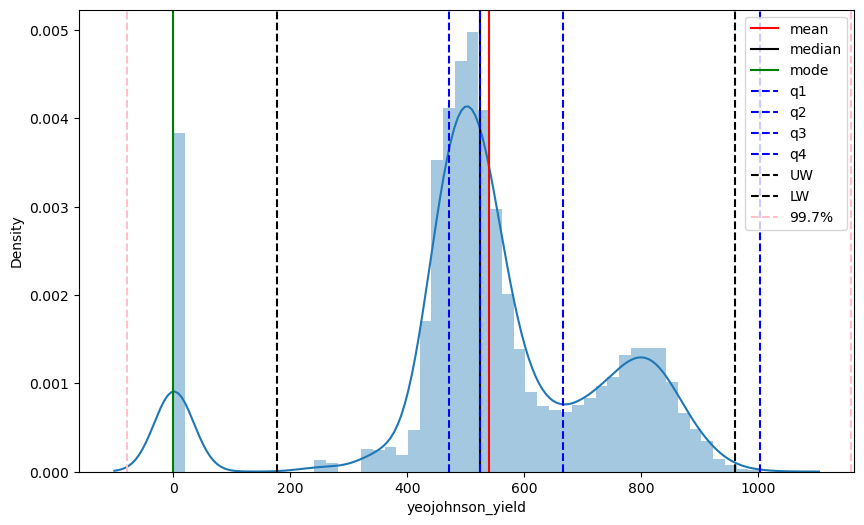

In [ ]:
dist_nor_plot(ing_w_farm_id_77519['yeojohnson_yield'])

### Step 9: Correlation plots

In [ ]:
# this skewness is all because of this 0's.
# lets see why there are 0's is there any relation between the yield and other independent features

<AxesSubplot:>

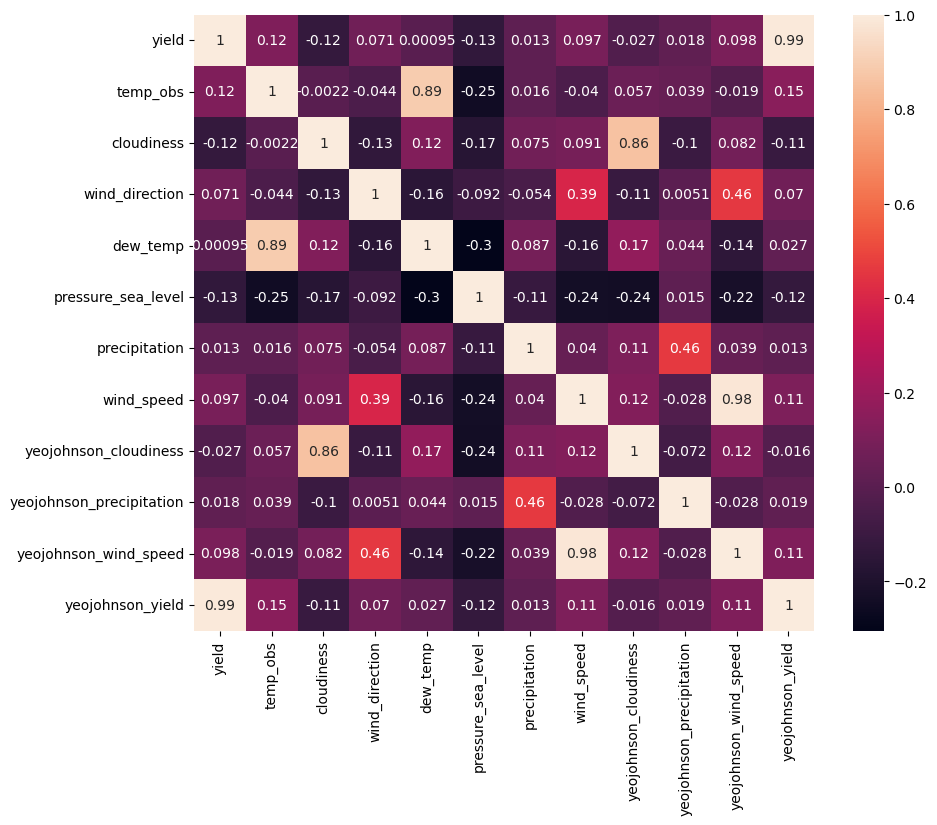

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(ing_w_farm_id_77519.corr(),annot=True)

In [ ]:
# there is no strong relation between the independent variables and dependent variables

In [ ]:
import plotly.express as px


# px.scatter(data_frame=farm_id_77519,x='temp_obs',y='yeojohnson_yield',trendline='ols')
# px.scatter(data_frame=farm_id_77519,x='cloudiness',y='yeojohnson_yield',trendline='ols')
# px.scatter(data_frame=farm_id_77519,x='wind_direction',y='yeojohnson_yield',trendline='ols')
# px.scatter(data_frame=farm_id_77519,x='dew_temp',y='yeojohnson_yield',trendline='ols')
# px.scatter(data_frame=farm_id_77519,x='pressure_sea_level',y='yeojohnson_yield',trendline='ols')
# px.scatter(data_frame=farm_id_77519,x='precipitation',y='yeojohnson_yield',trendline='ols')
# px.scatter(data_frame=farm_id_77519,x='wind_speed',y='yeojohnson_yield',trendline='ols')

In [ ]:
px.scatter(data_frame=ing_w_farm_id_77519,x='temp_obs',y='dew_temp',trendline='ols')

In [ ]:
# To understand the data we have to decompose it.
from statsmodels.tsa.seasonal import seasonal_decompose

#### Step 10: Extracting features from the time stamp

In [ ]:
# to decompose the data the index must be the time stamp
# so before making the timestamp as index lets extract the data from it
# extracting the hour
ing_w_farm_id_77519['hour']=ing_w_farm_id_77519['timestamp'].dt.hour
# extracting the day
ing_w_farm_id_77519['day']=ing_w_farm_id_77519['timestamp'].dt.day
# extracting the day of the week
ing_w_farm_id_77519["day_of_week"] = ing_w_farm_id_77519['timestamp'].dt.dayofweek
# extracting the week
ing_w_farm_id_77519["week"] = ing_w_farm_id_77519['timestamp'].dt.week
# extracting the month
ing_w_farm_id_77519['month']=ing_w_farm_id_77519['timestamp'].dt.month
# extracting the year
# ing_w_farm_id_77519['year']=ing_w_farm_id_77519['timestamp'].dt.year

#### Step 11: Conversion of Time Stamp to index

In [ ]:
ing_w_farm_id_77519.set_index('timestamp',inplace=True)

#### Step 12: Decomposition of Data

<Figure size 1500x800 with 0 Axes>

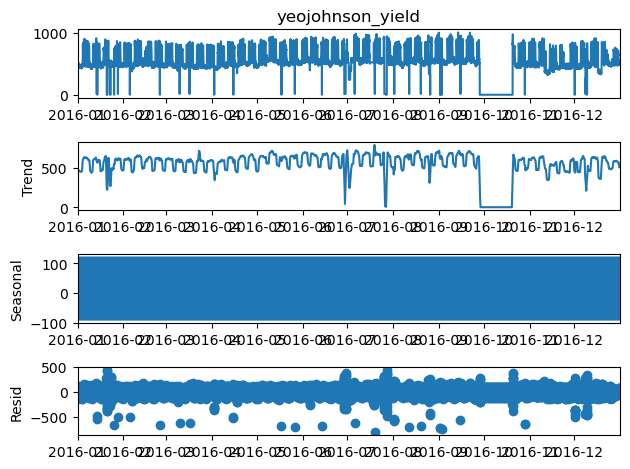

In [ ]:
decomposition = seasonal_decompose(ing_w_farm_id_77519['yeojohnson_yield'])
fig = plt.figure(figsize=(15,8))
decomposition.plot()
plt.show()

<Figure size 1500x800 with 0 Axes>

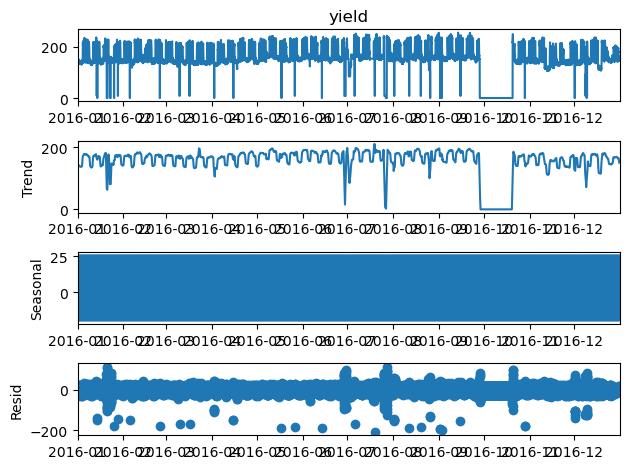

In [ ]:
decomposition = seasonal_decompose(ing_w_farm_id_77519['yield'])
fig = plt.figure(figsize=(15,8))
decomposition.plot()
plt.show()

In [ ]:
# no trend and seasonality is contant so using additive seasonality will be useful

In [ ]:
# lets see the decomposition for only one month
# a jan has total of 744 hours

# month       day   hours
# January  -- 31 -- 744
# February -- 29 -- 696 (leap year)
# March    -- 31 -- 744
# April    -- 30 -- 720
# May      -- 31 -- 744
# June     -- 30 -- 720
# July     -- 31 -- 744
# August   -- 31 -- 744
# September-- 30 -- 720
# October  -- 31 -- 744
# November -- 30 -- 720
# December -- 31 -- 744
# Leap Year-- 366-- 8784

# to extract that lets add a time seq column which will help to split the data

In [ ]:
# splitting data manually
import numpy as np
ing_w_farm_id_77519['Time_seq'] = np.arange(1,len(ing_w_farm_id_77519)+1)

In [ ]:
 # splitting the data manually for only one month
train = ing_w_farm_id_77519.loc[ing_w_farm_id_77519.Time_seq <=744]
# test = ing_w_farm_id_77519.loc[ing_w_farm_id_77519.Time_seq >744]

In [ ]:
print(train.index.min())
print(train.index.max())
# print(test.index.min())
# print(test.index.max())

2016-01-01 00:00:00
2016-01-31 23:00:00


<Figure size 1500x800 with 0 Axes>

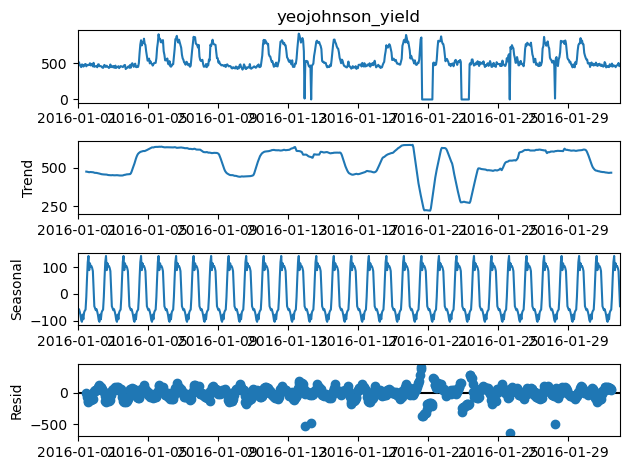

In [ ]:
decomposition = seasonal_decompose(train['yeojohnson_yield'])
fig = plt.figure(figsize=(15,8))
decomposition.plot()
plt.show()

<Figure size 1500x800 with 0 Axes>

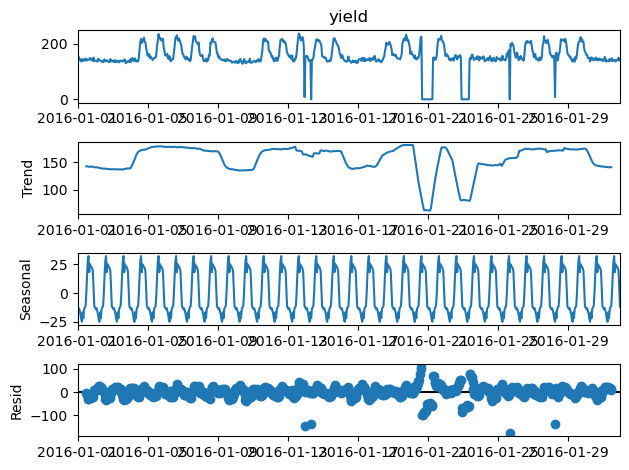

In [ ]:
decomposition = seasonal_decompose(train['yield'])
fig = plt.figure(figsize=(15,8))
decomposition.plot()
plt.show()

In [ ]:
# still no trend but constant seasonality.

#### Step 13: Split the data Manually

In [ ]:
# lets split the data and try different models.
 # splitting the data manually for 10 months as train and two months as test.
train = ing_w_farm_id_77519.loc[ing_w_farm_id_77519.Time_seq <=7320]
test = ing_w_farm_id_77519.loc[ing_w_farm_id_77519.Time_seq >7320]

In [ ]:
print(train.index.min())
print(train.index.max())
print(test.index.min())
print(test.index.max())

2016-01-01 00:00:00
2016-10-31 23:00:00
2016-11-01 00:00:00
2016-12-31 23:00:00


#### End of Data Preprocessing

#### Model Building

#### farm_id_77519

#### Model 1 : Simple linear regresson   
#### Model 2 : Multi linear regresson    
#### Model 3 : Lasso Regression          
#### Model 4 : Ridge Regression          
#### Model 5 : Decision Tree Regressor   
#### Model 6 : Random Forest Regressor   
#### Model 7 : GradientBoostingRegressor 

#### time series models

#### Model 8 : Arimax              
#### Model 9 : Holt's Winter                     
#### Model 10: Arima                    
#### Model 11: SArima                    
#### Model 12: Auto Arima                

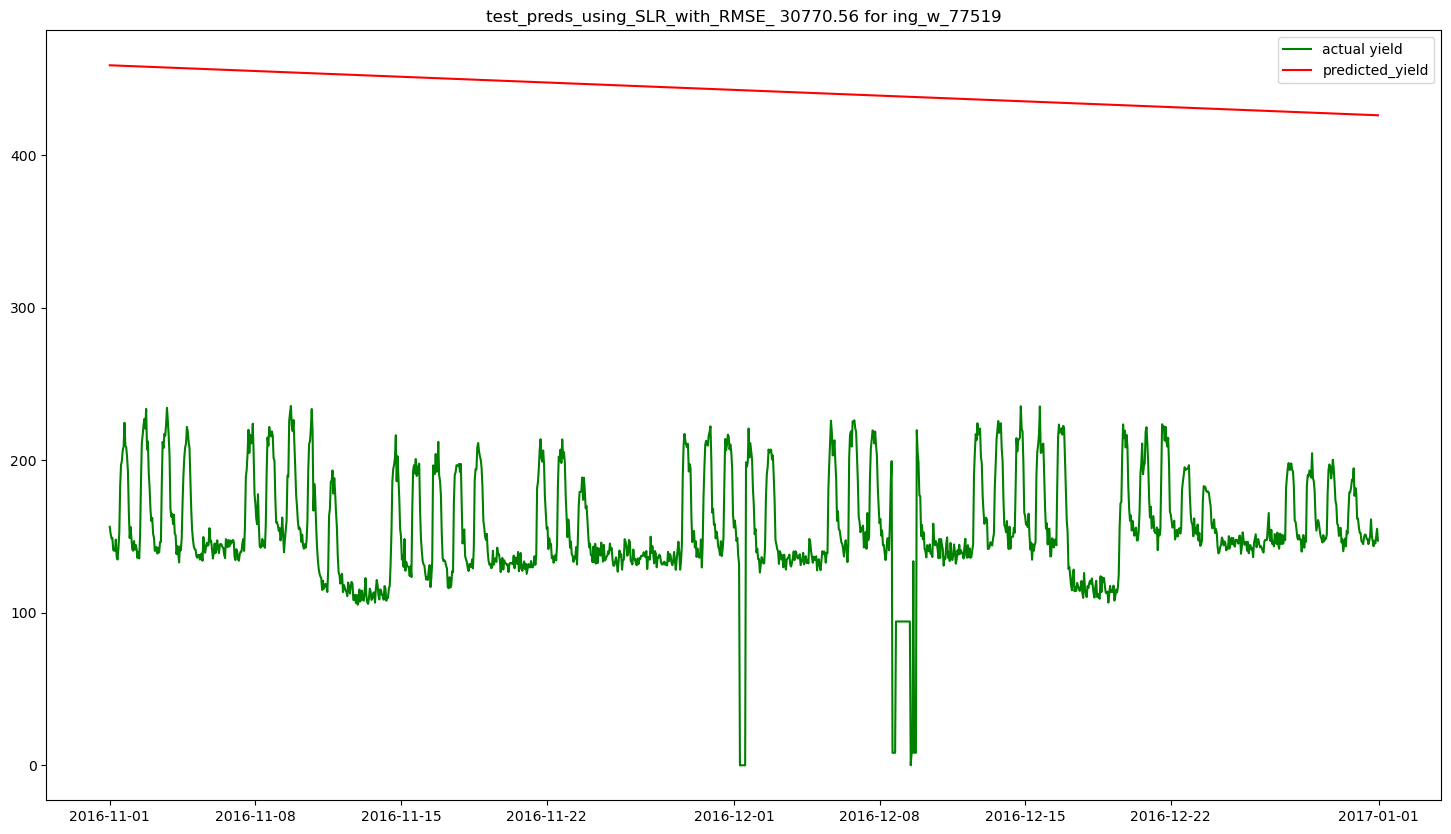

In [ ]:
# lets start with a Linear Model Simple Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr=LinearRegression()
lr.fit(train[['Time_seq']],train[['yeojohnson_yield']])
test_preds_lr=lr.predict(test[['Time_seq']])
plt.figure(figsize=(18,10))
plt.plot(test.index,test['yield'],label='actual yield',color='green')
plt.plot(test.index,test_preds_lr,label='predicted_yield',color='red')
plt.title("test_preds_using_SLR_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(test["yeojohnson_yield"],test_preds_lr))))
plt.legend()
plt.show()

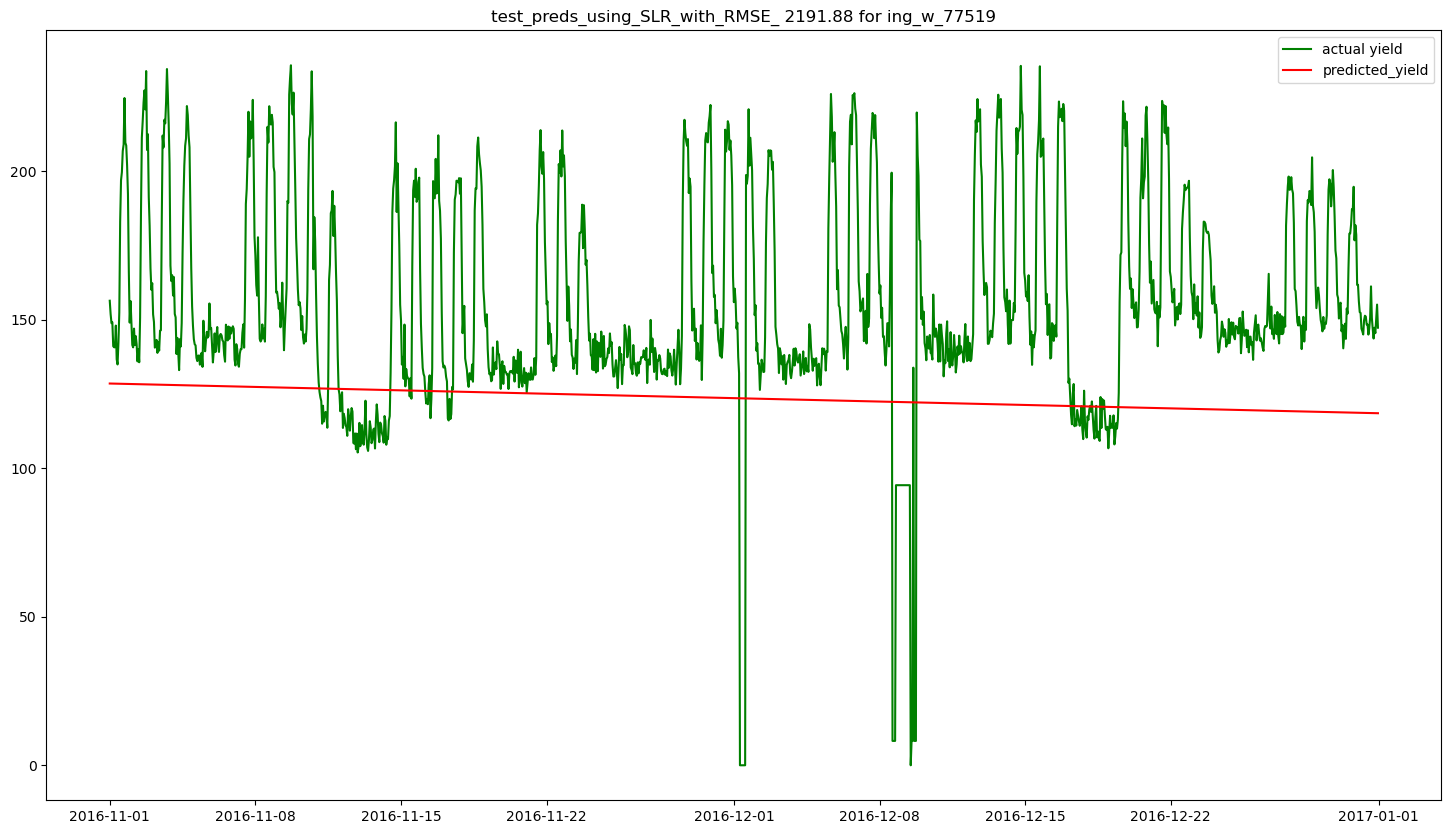

In [ ]:
lr.fit(train[['Time_seq']],train[['yield']])
test_preds_lr=lr.predict(test[['Time_seq']])
plt.figure(figsize=(18,10))
plt.plot(test.index,test['yield'],label='actual yield',color='green')
plt.plot(test.index,test_preds_lr,label='predicted_yield',color='red')
plt.title("test_preds_using_SLR_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(test["yield"],test_preds_lr))))
plt.legend()
plt.show()

In [ ]:
30770-2191
# normal values are giving best results than transformed values.

28579

In [ ]:
# there is no trend in our data
# linear regression can only capable of capturing the trend.


# so lets add the seasonality to it. 
# to do multiplicative seasonality our data zeros.
# (as our data has no trend but constant seasonality )
# we are using additive seasonality.

In [ ]:
# seasonlaity can be give to our model in two ways
# Incoporating the seasonality using Dummy variable approach
# Incorporating the seasonality by finding seasonality index and adding it the predictions.

# Incorporating seasonality will be done here.

In [ ]:
train['hour']=train['hour'].astype("category")
test['hour']=test['hour'].astype("category")
train['day']=train['day'].astype("category")
test['day']=test['day'].astype("category")
train['day_of_week']=train['day_of_week'].astype("category")
test['day_of_week']=test['day_of_week'].astype("category")
train['week']=train['week'].astype("category")
test['week']=test['week'].astype("category")
train['month']=train['month'].astype("category")
test['month']=test['month'].astype("category")
# train['year']=train['year'].astype("category")
# test['year']=test['year'].astype("category")

In [ ]:
# Dummification
train_dummy = pd.get_dummies(train[['hour','day','day_of_week', 'week','month']],dtype='int8')
test_dummy = pd.get_dummies(test[['hour','day','day_of_week', 'week','month']],dtype='int8')

In [ ]:
dummified_train_data=pd.concat([train,train_dummy],axis=1)
dummified_test_data=pd.concat([test,test_dummy],axis=1)

In [ ]:
dummified_train_data.drop(['hour','day','day_of_week', 'week','month'],axis=1,inplace=True)
dummified_test_data.drop(['hour','day','day_of_week', 'week','month'],axis=1,inplace=True)

In [ ]:
print(dummified_train_data.shape)
print(dummified_test_data.shape)

(7320, 130)
(1464, 86)


In [ ]:
# as we  can see dummified data train data has 130 columns and in test data has 86 cols 
# as we are using 10 months in train data we are getting 130 columns and 2 months in test 

# our predictions for next year to predict the next year our test data must have all the months.

In [ ]:
train_align,test_align = dummified_train_data.align(dummified_test_data, join='outer', axis=1,fill_value=0)

In [ ]:
print(train_align.shape,test_align.shape)

(7320, 140) (1464, 140)


In [ ]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
train_align.head(1)

Time_seq  cloudiness  day_1  day_10  day_11  day_12  day_13  \
timestamp                                                                 
2016-01-01         1         0.0      1       0       0       0       0   

            day_14  day_15  day_16  day_17  day_18  day_19  day_2  day_20  \
timestamp                                                                   
2016-01-01       0       0       0       0       0       0      0       0   

            day_21  day_22  day_23  day_24  day_25  day_26  day_27  day_28  \
timestamp                                                                    
2016-01-01       0       0       0       0       0       0       0       0   

            day_29  day_3  day_30  day_31  day_4  day_5  day_6  day_7  day_8  \
timestamp                                                                      
2016-01-01       0      0       0       0      0      0      0      0      0   

            day_9  day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  \
timestamp                                                                       
2016-01-01      0              0              0              0              0   

            day_of_week_4  day_of_week_5  day_of_week_6  dew_temp  hour_0  \
timestamp                                                                   
2016-01-01              1              0              0      -0.6       1   

            hour_1  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
timestamp                                                                  
2016-01-01       0        0        0        0        0        0        0   

            hour_16  hour_17  hour_18  hour_19  hour_2  hour_20  hour_21  \
timestamp                                                                  
2016-01-01        0        0        0        0       0        0        0   

            hour_22  hour_23  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  \
timestamp                                                                      
2016-01-01        0        0       0       0       0       0       0       0   

            hour_9  month_1  month_10  month_11  month_12  month_2  month_3  \
timestamp                                                                     
2016-01-01       0        1         0         0         0        0        0   

            month_4  month_5  month_6  month_7  month_8  month_9  \
timestamp                                                          
2016-01-01        0        0        0        0        0        0   

            precipitation  pressure_sea_level  temp_obs  week_1  week_10  \
timestamp                                                                  
2016-01-01            0.0         1019.299988       5.6       0        0   

            week_11  week_12  week_13  week_14  week_15  week_16  week_17  \
timestamp                                                                   
2016-01-01        0        0        0        0        0        0        0   

            week_18  week_19  week_2  week_20  week_21  week_22  week_23  \
timestamp                                                                  
2016-01-01        0        0       0        0        0        0        0   

            week_24  week_25  week_26  week_27  week_28  week_29  week_3  \
timestamp                                                                  
2016-01-01        0        0        0        0        0        0       0   

            week_30  week_31  week_32  week_33  week_34  week_35  week_36  \
timestamp                                                                   
2016-01-01        0        0        0        0        0        0        0   

            week_37  week_38  week_39  week_4  week_40  week_41  week_42  \
timestamp                                                                  
2016-01-01        0        0        0       0        0        0        0   

            week_43  week_44  week_45  week_46  week_47  week_48  week_49  \
tim

In [ ]:
x_train=train_align.drop(['yeojohnson_yield','yield','wind_speed','precipitation','cloudiness'],axis=1)
y_train=train_align[['yeojohnson_yield']]
x_test=test_align.drop(['yeojohnson_yield','yield','wind_speed','precipitation','cloudiness'],axis=1)
y_test=test_align[['yeojohnson_yield']]

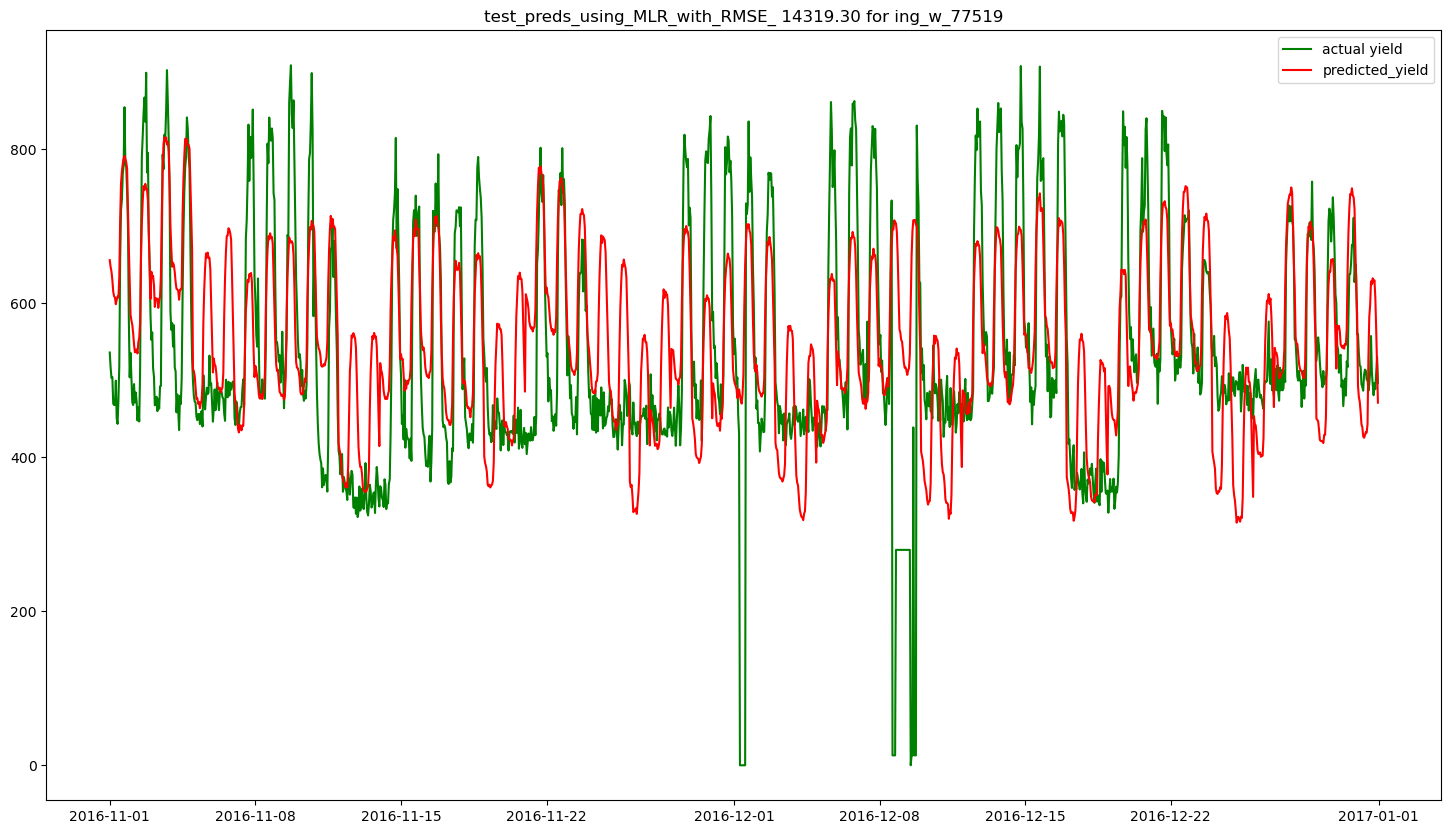

In [ ]:
# Multi Linear Regression (Incorporting Seasonality using Dummy Variable Approach)
mlr=LinearRegression()
mlr.fit(x_train,y_train)
test_preds_mlr=mlr.predict(x_test)
plt.figure(figsize=(18,10))
plt.plot(y_test.index,y_test['yeojohnson_yield'],label='actual yield',color='green')
plt.plot(y_test.index,test_preds_mlr,label='predicted_yield',color='red')
plt.title("test_preds_using_MLR_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(y_test['yeojohnson_yield'],test_preds_mlr))))
plt.legend()
plt.show()

In [ ]:
x_train=train_align.drop(['yeojohnson_yield','yield','yeojohnson_wind_speed','yeojohnson_precipitation','yeojohnson_cloudiness'],axis=1)
y_train=train_align[['yield']]
x_test=test_align.drop(['yeojohnson_yield','yield','yeojohnson_wind_speed','yeojohnson_precipitation','yeojohnson_cloudiness'],axis=1)
y_test=test_align[['yield']]

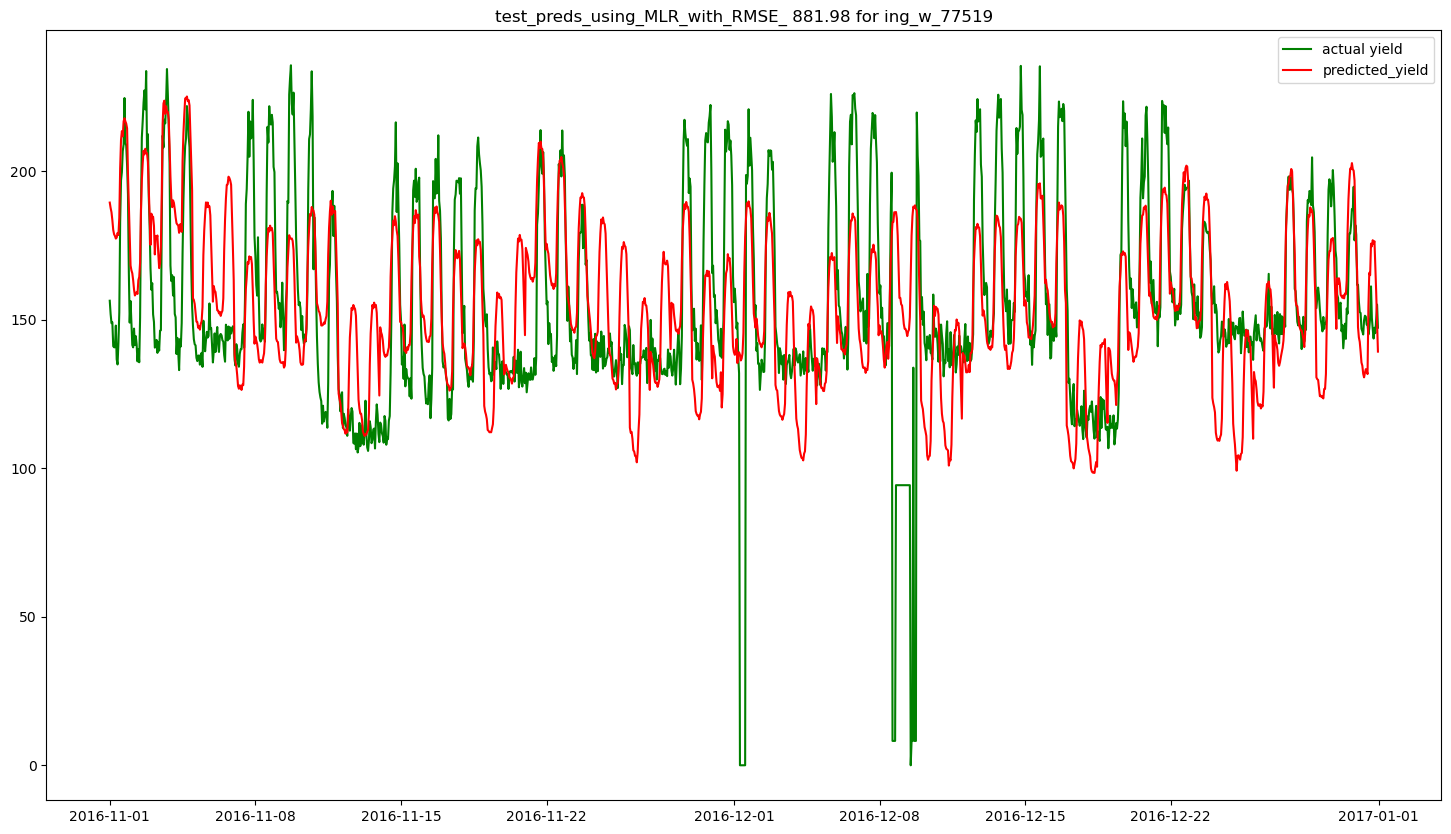

In [ ]:
# Multi Linear Regression (Incorporting Seasonality using Dummy Variable Approach)
mlr=LinearRegression()
mlr.fit(x_train,y_train)
test_preds_mlr=mlr.predict(x_test)
plt.figure(figsize=(18,10))
plt.plot(y_test.index,y_test['yield'],label='actual yield',color='green')
plt.plot(y_test.index,test_preds_mlr,label='predicted_yield',color='red')
plt.title("test_preds_using_MLR_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(y_test['yield'],test_preds_mlr))))
plt.legend()
plt.show()

1461.191339689493


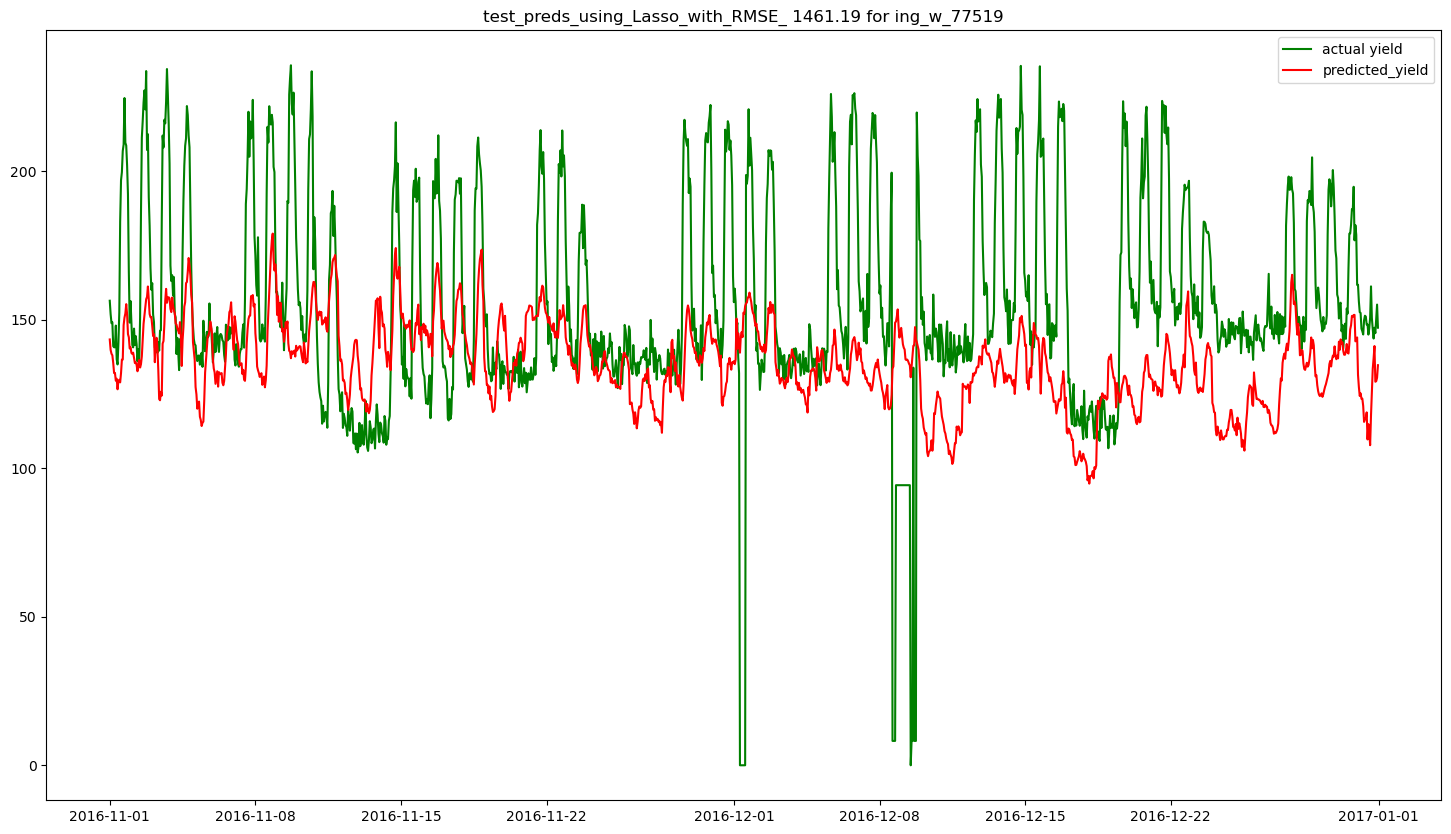

In [ ]:
from sklearn.linear_model import Lasso
la=Lasso()
la.fit(x_train,y_train)
test_preds_la=la.predict(x_test)
print(mean_squared_error(y_test['yield'],test_preds_la))
plt.figure(figsize=(18,10))
plt.plot(y_test.index,y_test['yield'],label='actual yield',color='green')
plt.plot(y_test.index,test_preds_la,label='predicted_yield',color='red')
plt.title("test_preds_using_Lasso_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(y_test['yield'],test_preds_la))))
plt.legend()
plt.show()

892.2578490760682


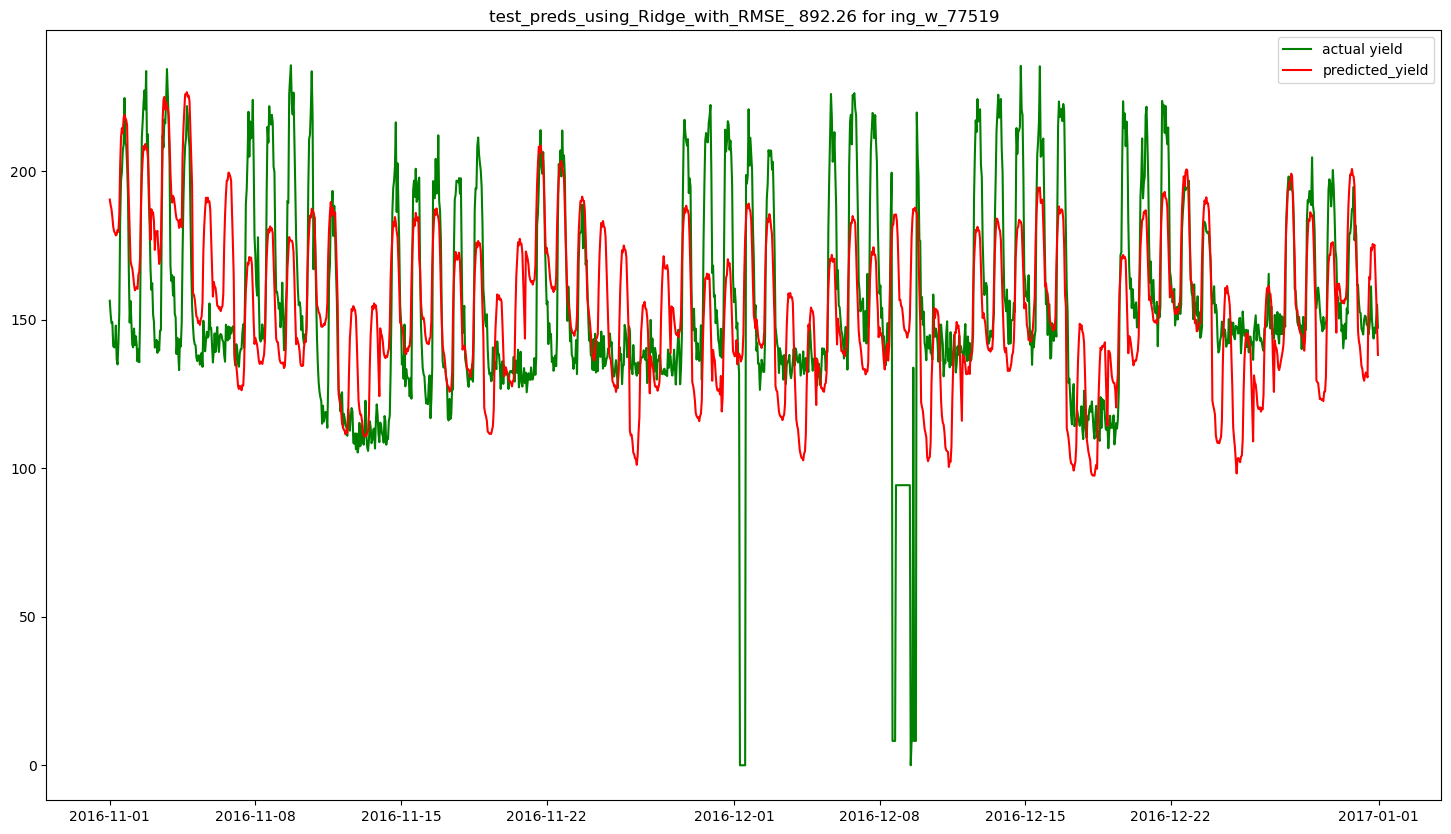

In [ ]:
from sklearn.linear_model import Ridge
ri=Ridge()
ri.fit(x_train,y_train)
test_preds_ri=ri.predict(x_test)
print(mean_squared_error(y_test['yield'],test_preds_ri))
plt.figure(figsize=(18,10))
plt.plot(y_test.index,y_test['yield'],label='actual yield',color='green')
plt.plot(y_test.index,test_preds_ri,label='predicted_yield',color='red')
plt.title("test_preds_using_Ridge_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(y_test['yield'],test_preds_ri))))
plt.legend()
plt.show()

9551.993406574951


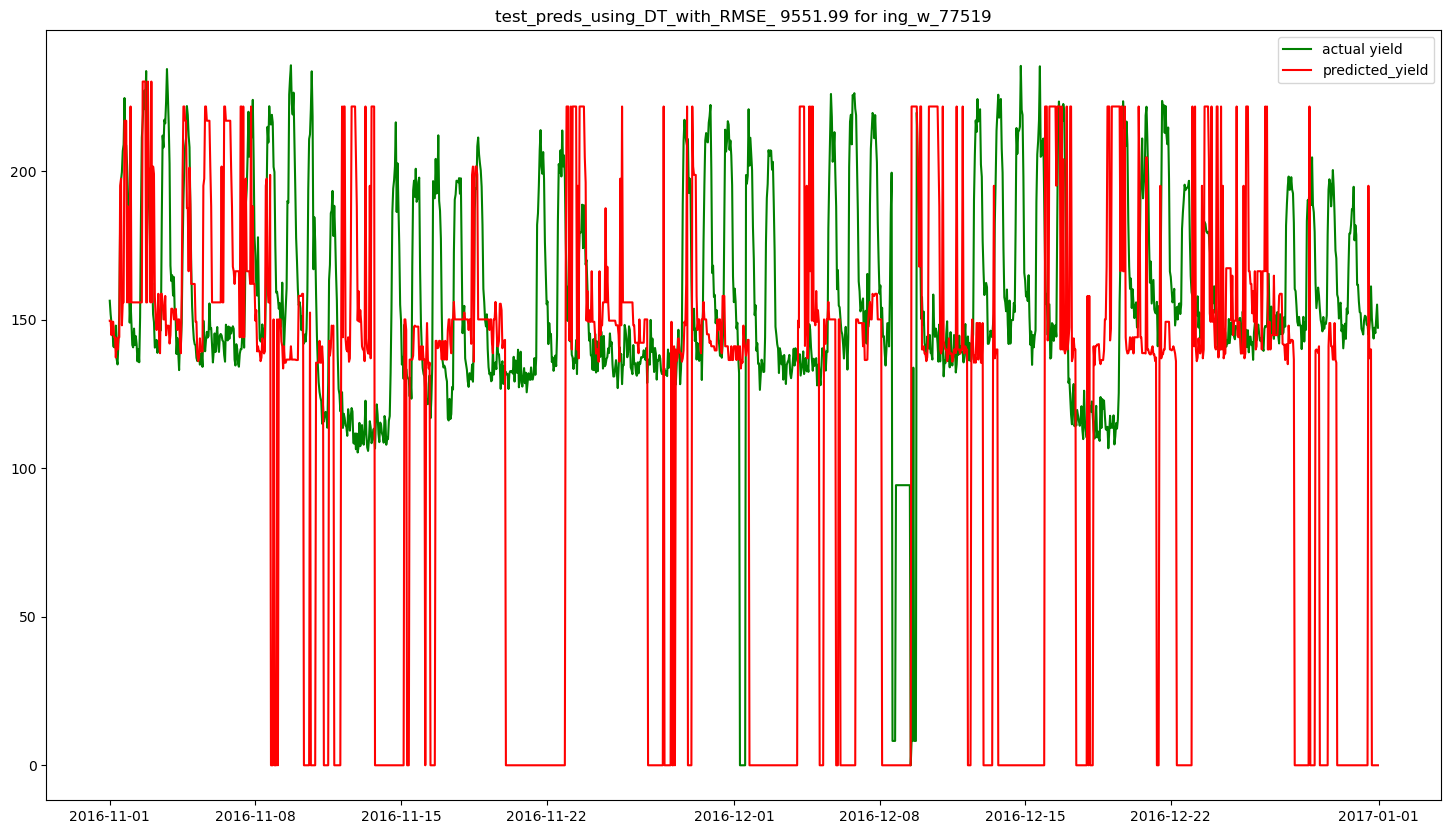

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor()
dtr.fit(x_train,y_train)
test_preds_dtr=dtr.predict(x_test)
print(mean_squared_error(y_test['yield'],test_preds_dtr))
plt.figure(figsize=(18,10))
plt.plot(y_test.index,y_test['yield'],label='actual yield',color='green')
plt.plot(y_test.index,test_preds_dtr,label='predicted_yield',color='red')
plt.title("test_preds_using_DT_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(y_test['yield'],test_preds_dtr))))
plt.legend()
plt.show()

1393.650037442194


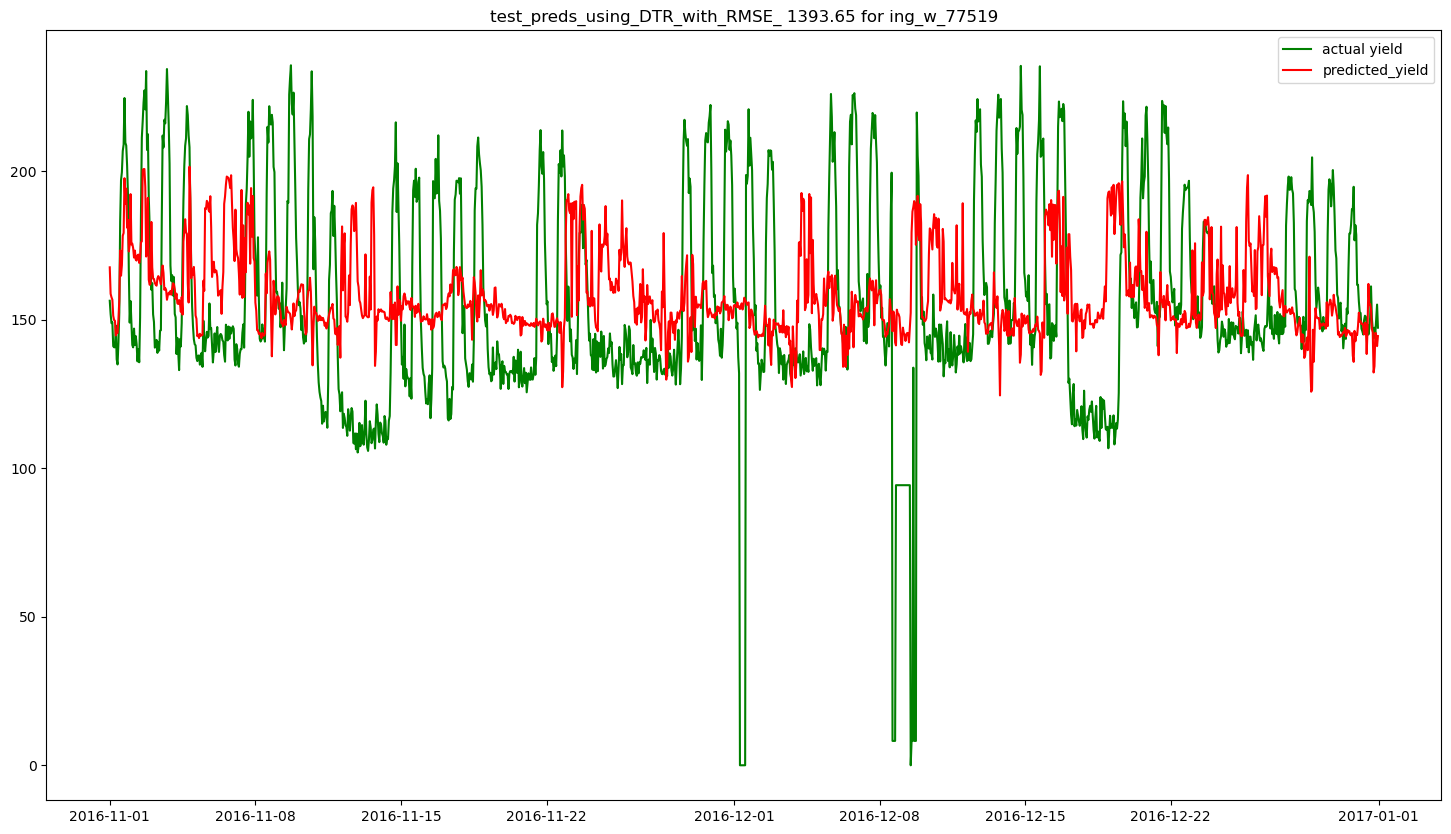

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=1000,random_state=None)
rf.fit(x_train,y_train)
test_preds_rf=rf.predict(x_test)
print(mean_squared_error(y_test['yield'],test_preds_rf))
plt.figure(figsize=(18,10))
plt.plot(y_test.index,y_test['yield'],label='actual yield',color='green')
plt.plot(y_test.index,test_preds_rf,label='predicted_yield',color='red')
plt.title("test_preds_using_DTR_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(y_test['yield'],test_preds_rf))))
plt.legend()
plt.show()

795.9556858573873


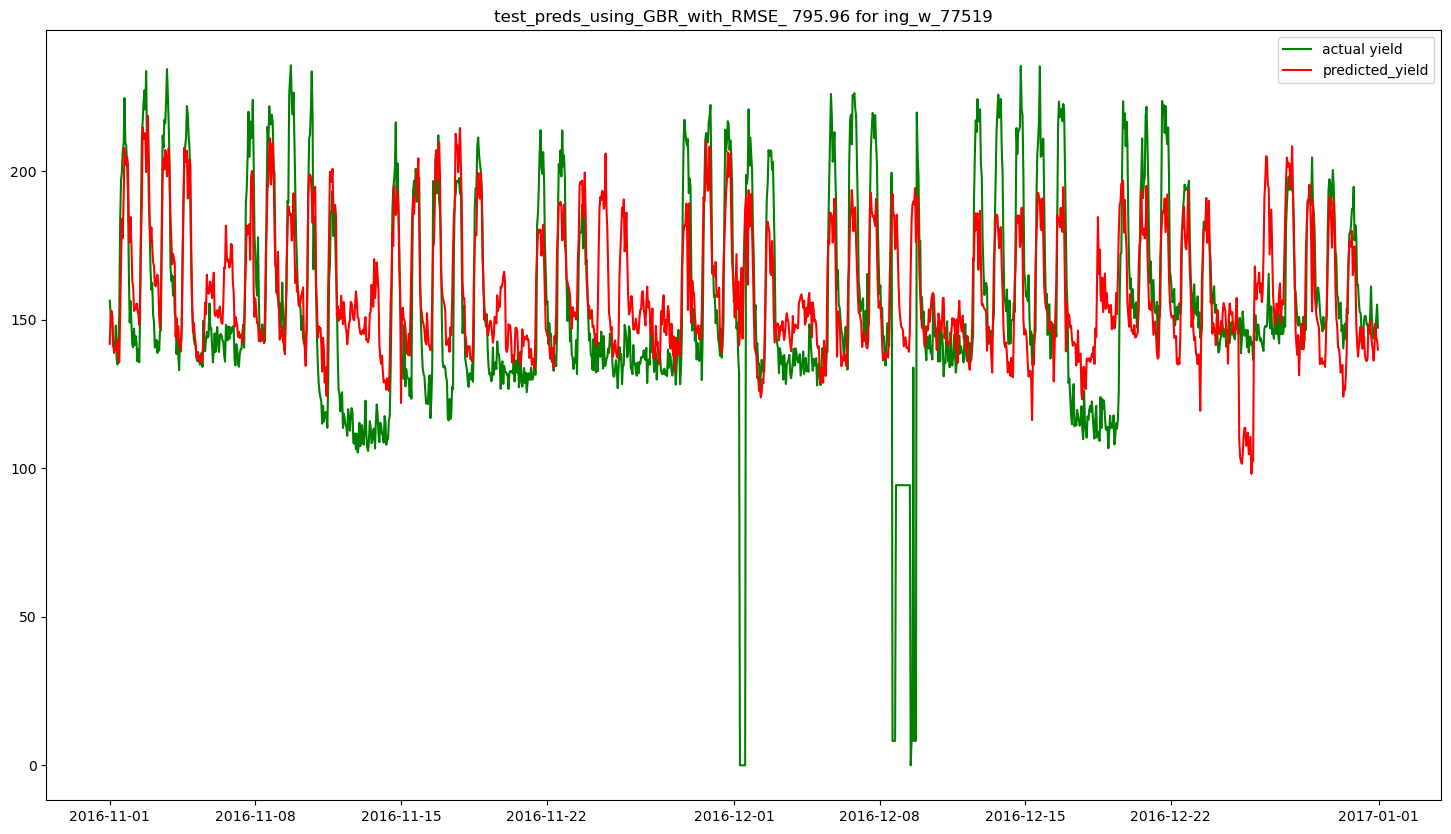

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr=GradientBoostingRegressor(n_estimators = 1000,criterion='mse')
gbr.fit(x_train,y_train)
test_preds_gbr=gbr.predict(x_test)
print(mean_squared_error(y_test['yield'],test_preds_gbr))
plt.figure(figsize=(18,10))
plt.plot(y_test.index,y_test['yield'],label='actual yield',color='green')
plt.plot(y_test.index,test_preds_gbr,label='predicted_yield',color='red')
plt.title("test_preds_using_GBR_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(y_test['yield'],test_preds_gbr))))
plt.legend()
plt.show()

# Time Series Models

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#### ACF and PACF Graphs

In [ ]:
import statsmodels.api as sm

Figure(640x480)
Figure(640x480)


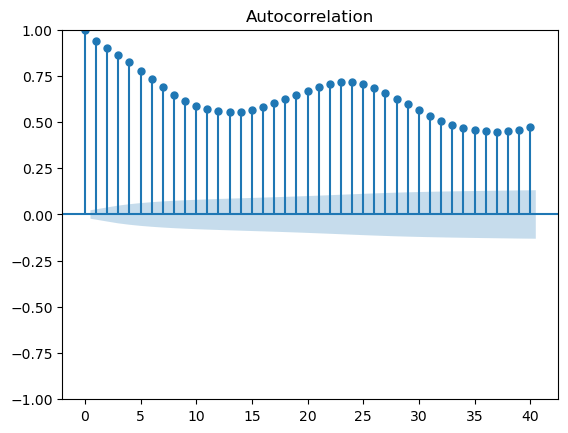

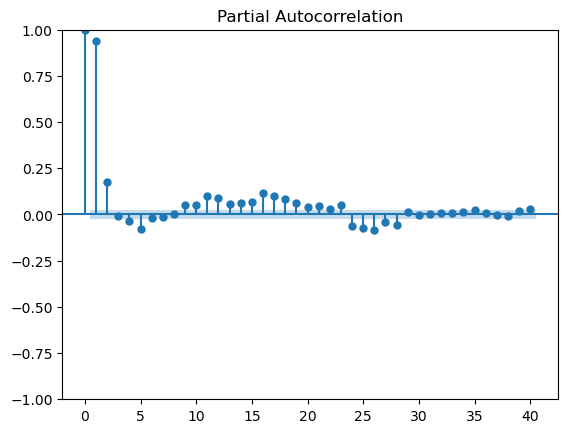

In [ ]:
print(sm.graphics.tsa.plot_acf(y_train['yield'], lags=40))
print(sm.graphics.tsa.plot_pacf(y_train['yield'], lags=40))

In [ ]:
# because our ACF graph had a suspension bridge and positive and negative spikes in PACF
# it says that our data is non stationary and had strong seasonality.

# both the plots having many significant spikes and a suspensional bridge we can use ARIMA model

# ar 2? mv? d?

# our data is non stationary

# data is considers as stationary when the statistical properties of the data is constant.
# if not our data is stationary

# to make the non stationary data to stationary we need of differencing

# some times the differencing might work and sometimes won't.

# differncing is like we are transforming the non linear data to linear in stats models.

# even if differencing won't works then we can use linear transformations.

### ARIMAX

In [ ]:
train_exog=['Time_seq','cloudiness','day_1','day_10','day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_2','day_20','day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_3','day_30','day_31','day_4','day_5','day_6','day_7','day_8','day_9','day_of_week_0','day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4','day_of_week_5','day_of_week_6','dew_temp','hour_0','hour_1','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_2','hour_20','hour_21','hour_22','hour_23','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','month_1','month_10','month_11','month_12','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','precipitation','pressure_sea_level','temp_obs','week_1','week_10','week_11','week_12','week_13','week_14','week_15','week_16','week_17','week_18','week_19','week_2','week_20','week_21','week_22','week_23','week_24','week_25','week_26','week_27','week_28','week_29','week_3','week_30','week_31','week_32','week_33','week_34','week_35','week_36','week_37','week_38','week_39','week_4','week_40','week_41','week_42','week_43','week_44','week_45','week_46','week_47','week_48','week_49','week_5','week_50','week_51','week_52','week_53','week_6','week_7','week_8','week_9','wind_direction','wind_speed']
test_exog=['Time_seq','cloudiness','day_1','day_10','day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_2','day_20','day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_3','day_30','day_31','day_4','day_5','day_6','day_7','day_8','day_9','day_of_week_0','day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4','day_of_week_5','day_of_week_6','dew_temp','hour_0','hour_1','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_2','hour_20','hour_21','hour_22','hour_23','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','month_1','month_10','month_11','month_12','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','precipitation','pressure_sea_level','temp_obs','week_1','week_10','week_11','week_12','week_13','week_14','week_15','week_16','week_17','week_18','week_19','week_2','week_20','week_21','week_22','week_23','week_24','week_25','week_26','week_27','week_28','week_29','week_3','week_30','week_31','week_32','week_33','week_34','week_35','week_36','week_37','week_38','week_39','week_4','week_40','week_41','week_42','week_43','week_44','week_45','week_46','week_47','week_48','week_49','week_5','week_50','week_51','week_52','week_53','week_6','week_7','week_8','week_9','wind_direction','wind_speed']

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                  yield   No. Observations:                 7320
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -31409.979
Date:                Sat, 25 Feb 2023   AIC                          63099.958
Time:                        07:18:35   BIC                          64065.710
Sample:                    01-01-2016   HQIC                         63431.997
                         - 10-31-2016                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Time_seq              -0.0010      0.250     -0.004      0.997      -0.492       0.490
cloudiness            -0.2085      0.266     -0.784      0.433      -0.729       0.312
day_1               

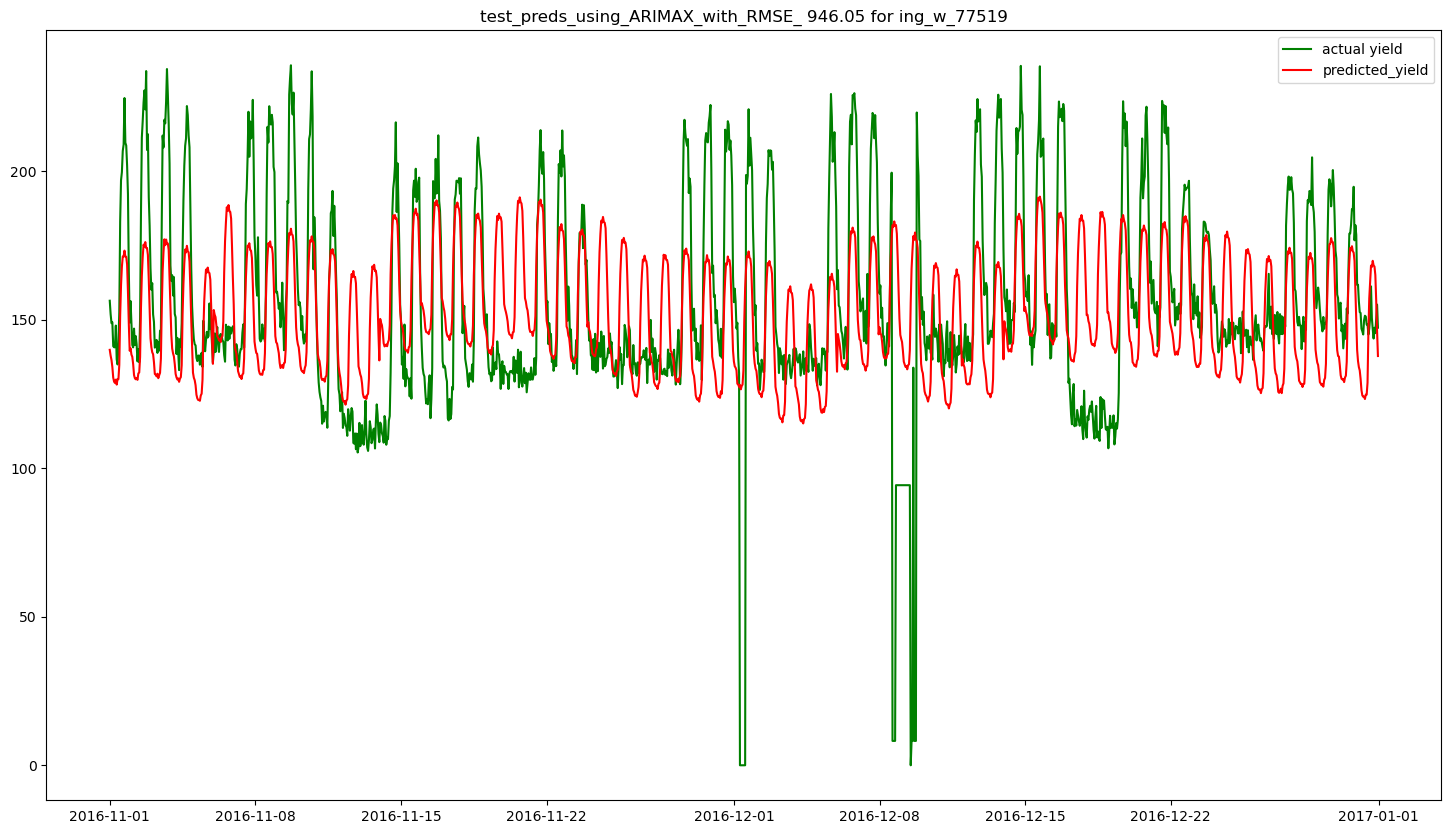

In [ ]:
model_arimax = ARIMA(y_train['yield'], order=(3,1,1), exog=x_train[train_exog])
results = model_arimax.fit()
print(results.summary())
test_preds_arimax = results.forecast(steps=len(test_align), exog=x_test[test_exog])
print(mean_squared_error(y_test['yield'],test_preds_arimax))
plt.figure(figsize=(18,10))
plt.plot(y_test.index,y_test['yield'],label='actual yield',color='green')
plt.plot(y_test.index,test_preds_arimax,label='predicted_yield',color='red')
plt.title("test_preds_using_ARIMAX_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(y_test['yield'],test_preds_arimax))))
plt.legend()
plt.show()

### Holt's Winter

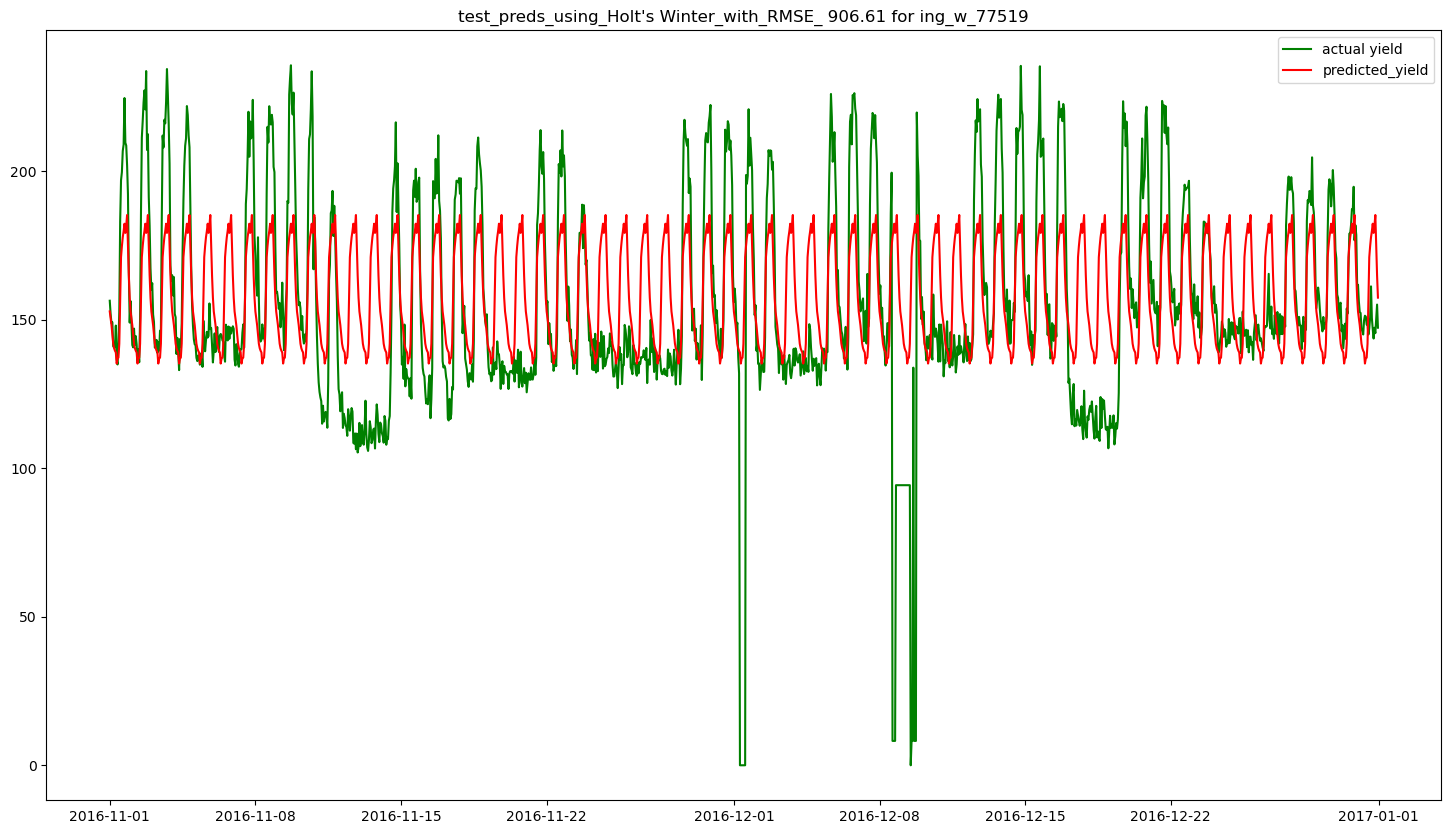

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing
holt_exp_add = ExponentialSmoothing(np.asarray(y_train['yield']) ,seasonal_periods=24, seasonal='additive',).fit()
test_Holt_Winter_preds = holt_exp_add.forecast(len(y_test['yield']))
plt.figure(figsize=(18,10))
plt.plot(y_test.index,y_test['yield'],label='actual yield',color='green')
plt.plot(y_test.index,test_Holt_Winter_preds,label='predicted_yield',color='red')
plt.title("test_preds_using_Holt's Winter_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(y_test['yield'],test_Holt_Winter_preds))))
plt.legend()
plt.show()

### ARIMA

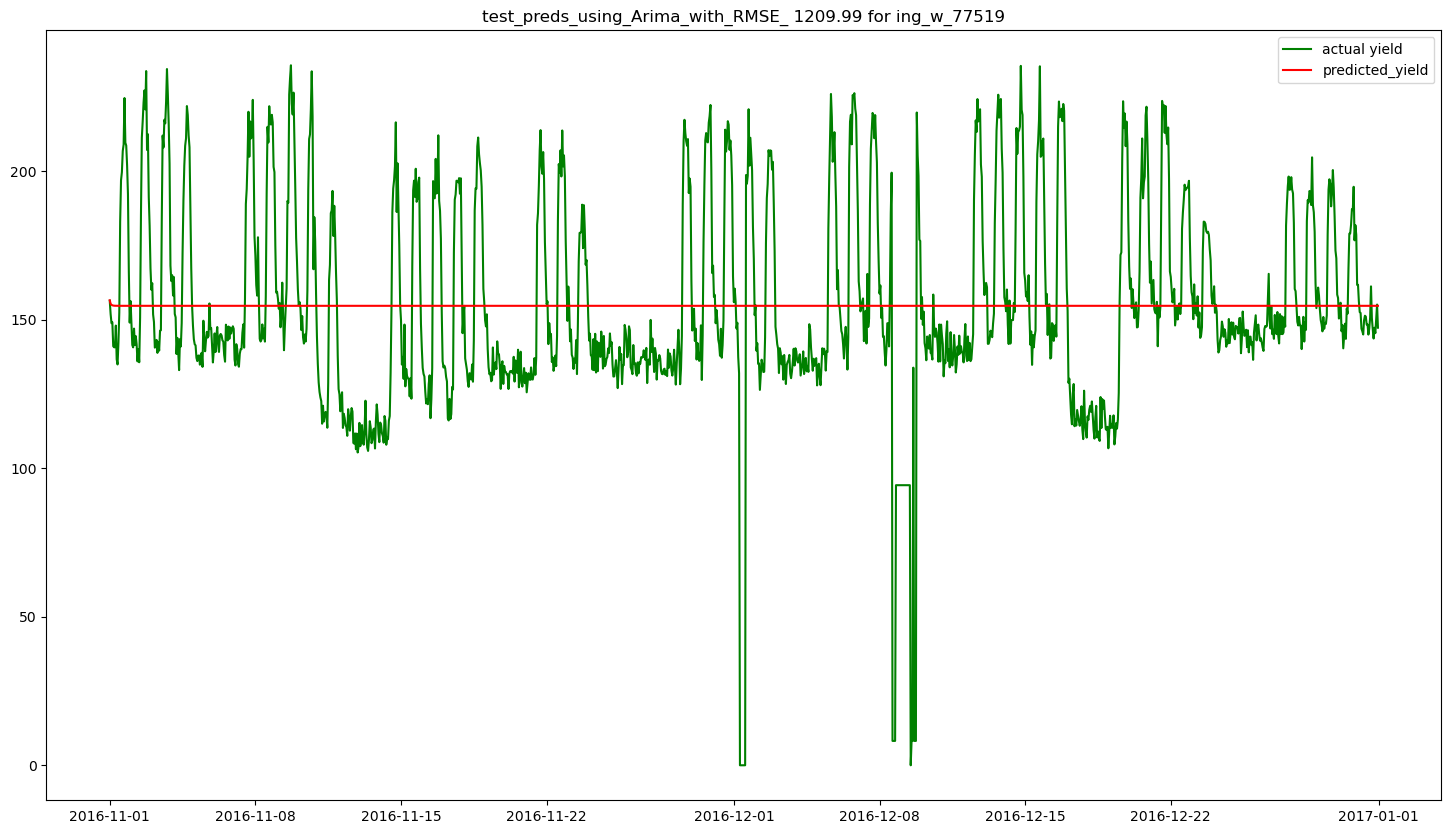

In [ ]:
model_arima = ARIMA(y_train['yield'].values, order=(3,1,1))
model_arima_fit = model_arima.fit()
model_arima_fit.summary()
test_Arima_preds = model_arima_fit.forecast(steps = len(y_test['yield']))
plt.figure(figsize=(18,10))
plt.plot(y_test.index,y_test['yield'],label='actual yield',color='green')
plt.plot(y_test.index,test_Arima_preds,label='predicted_yield',color='red')
plt.title("test_preds_using_Arima_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(y_test['yield'],test_Arima_preds))))
plt.legend()
plt.show()

### SARIMA

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



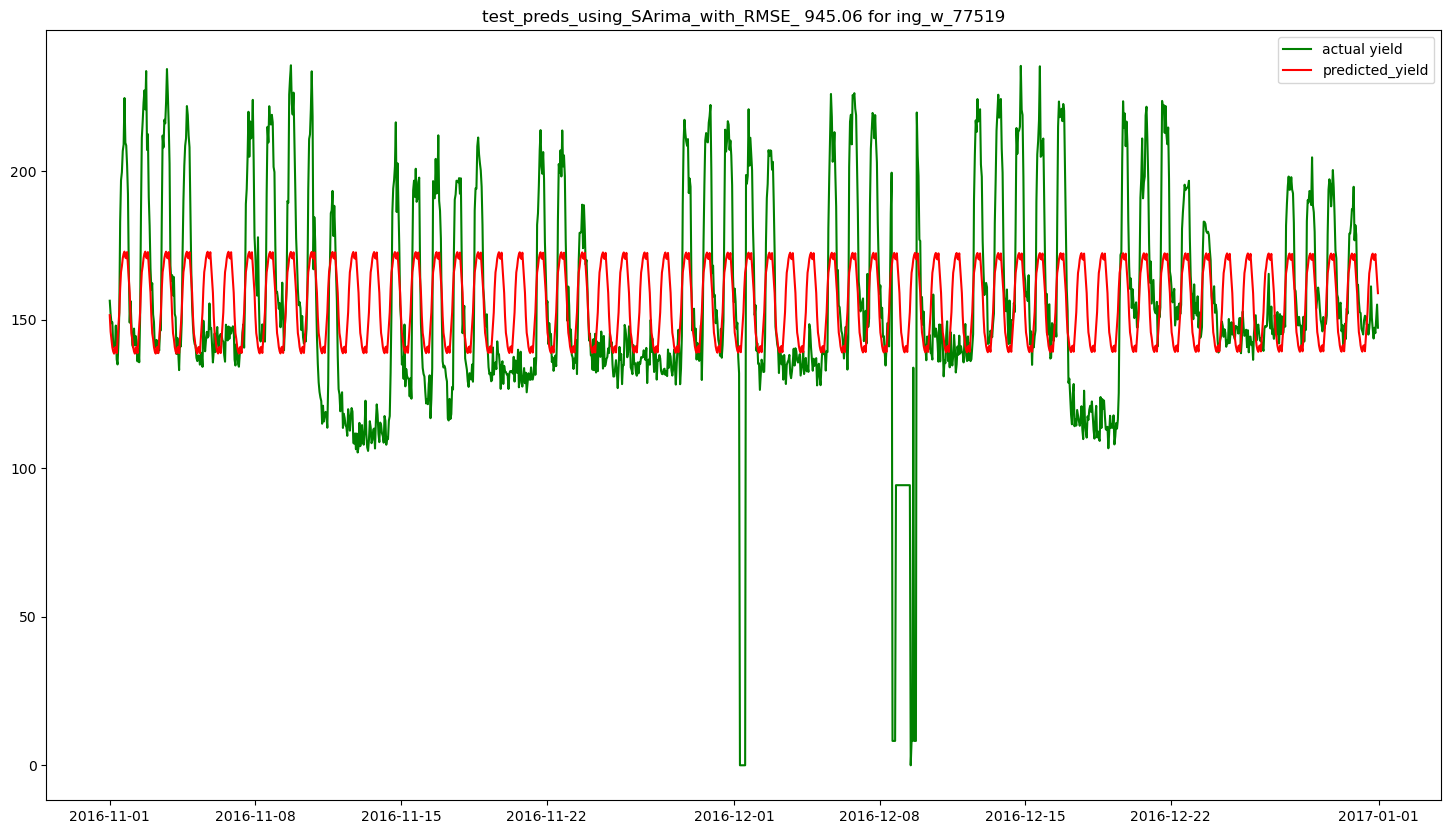

945.0584903673546


In [ ]:
# (0,1,2)x(2,0,[],24)
model_sarima = ARIMA(y_train['yield'].values, order=(3,1,1),seasonal_order=(1,0,1,12))
model_sarima_fit = model_sarima.fit()
model_sarima_fit.summary()
test_SArima_preds = model_sarima_fit.forecast(steps = len(y_test['yield']))

plt.figure(figsize=(18,10))
plt.plot(y_test.index,y_test['yield'],label='actual yield',color='green')
plt.plot(y_test.index,test_SArima_preds,label='predicted_yield',color='red')
plt.title("test_preds_using_SArima_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(y_test['yield'],test_SArima_preds))))
plt.legend()
plt.show()

print(mean_squared_error(y_test['yield'],test_SArima_preds,squared=True))

In [ ]:
!pip install pmdarima

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.8 MB/s eta 0:00:0000:0100:010m


In [ ]:
import pmdarima
from pmdarima.arima import auto_arima

In [ ]:
model_auto_arima = auto_arima(np.asarray(train['yield']),seasonal=True,m=24,start_p=1, start_q=1)
model_auto_arima.summary() 
test_preds_auto_arima_24=model_auto_arima.predict(n_periods=len(test['yield']))
mean_squared_error(test['yield'],test_preds_auto_arima_24)

1253.1531234607257

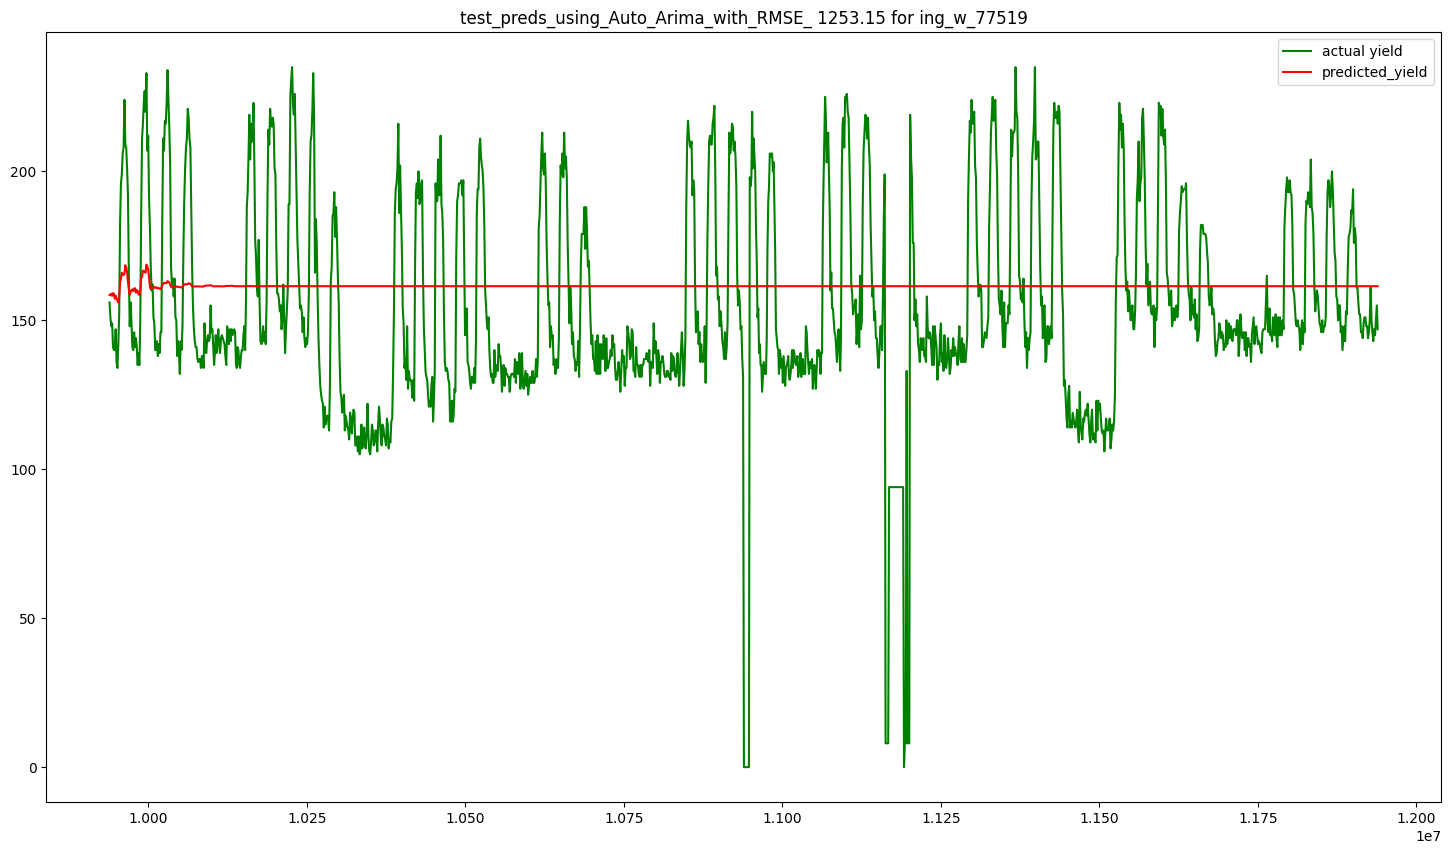

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
plt.plot(test.index,test['yield'],label='actual yield',color='green')
plt.plot(test.index,test_preds_auto_arima_24,label='predicted_yield',color='red')
plt.title("test_preds_using_Auto_Arima_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(test['yield'],test_preds_auto_arima_24))))
plt.legend()
plt.show()

In [ ]:
model_auto_arima.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 7320
Model:             SARIMAX(0, 1, 2)x(2, 0, [], 24)   Log Likelihood              -31870.783
Date:                             Fri, 24 Feb 2023   AIC                          63751.567
Time:                                     15:57:08   BIC                          63786.058
Sample:                                          0   HQIC                         63763.425
                                            - 7320                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2584      0.003    -87.063      0.000      -0.264      -0.253
ma.L2          0.0236      0.005      4.370      0.000       0.013       0.034
ar.S.L24       0.1311      0.006     22.541      0.000       0.120       0.143
ar.S.L48       0.1063      0.010     10.575      0.000       0.087       0.126
sigma2       354.6071      1.187    298.863      0.000     352.282     356.933
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1175030.61
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                            -0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        65.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# SARIMAX(0, 1, 2)x(2, 0, [], 24)

In [ ]:
# trying to do another farm with auto arima

In [ ]:
fid_110884=ing_w_data[ing_w_data['farm_id']=='fid_110884']

In [ ]:
import numpy as np
fid_110884['Time_seq'] = np.arange(1,len(fid_110884)+1)

In [ ]:
train_fid_110884 = fid_110884.loc[fid_110884.Time_seq <=7320]
test_fid_110884 = fid_110884.loc[fid_110884.Time_seq >7320]

In [ ]:
surendra

In [ ]:
model_auto_arima_new = auto_arima(np.asarray(train_fid_110884['yield']),seasonal=True,m=24,start_p=1, start_q=1)



In [ ]:
model_auto_arima_new.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 7320
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 24)   Log Likelihood              -28393.866
Date:                              Fri, 24 Feb 2023   AIC                          56799.732
Time:                                      17:16:00   BIC                          56841.121
Sample:                                           0   HQIC                         56813.962
                                             - 7320                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7393      0.010     70.771      0.000       0.719       0.760
ma.L1         -1.0716      0.010   -102.075      0.000      -1.092      -1.051
ma.L2          0.1511      0.006     25.656      0.000       0.140       0.163
ar.S.L24       0.7494      0.030     24.792      0.000       0.690       0.809
ma.S.L24      -0.6539      0.033    -19.902      0.000      -0.718      -0.589
sigma2       137.1263      0.172    798.807      0.000     136.790     137.463
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):          48587984.71
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              18.91   Skew:                             5.57
Prob(H) (two-sided):                  0.00   Kurtosis:                       402.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
test_preds_auto_arima_24_new=model_auto_arima_new.predict(n_periods=len(test_fid_110884['yield']))
mean_squared_error(test_fid_110884['yield'],test_preds_auto_arima_24_new)

1807.3999982778914

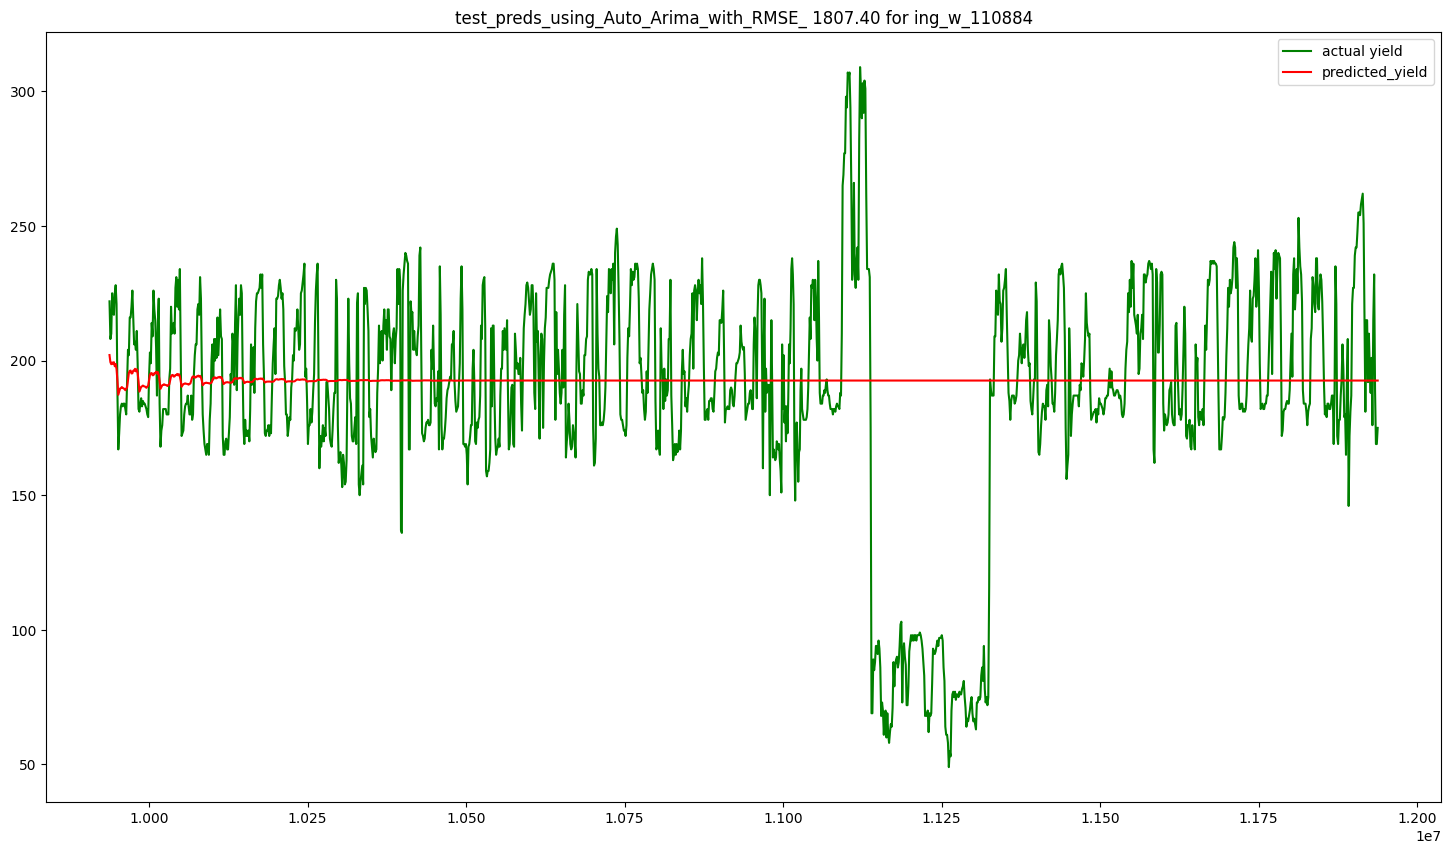

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
plt.plot(test_fid_110884.index,test_fid_110884['yield'],label='actual yield',color='green')
plt.plot(test_fid_110884.index,test_preds_auto_arima_24_new,label='predicted_yield',color='red')
plt.title("test_preds_using_Auto_Arima_with_RMSE_ {:.2f} for ing_w_110884".format(float(mean_squared_error(test_fid_110884['yield'],test_preds_auto_arima_24_new))))
plt.legend()
plt.show()

In [ ]:
# farm_id_77519

# Simple linear regresson   : 2191.88
# Multi linear regresson    : 881.97
# Lasso Regression          : 1461.19
# Ridge Regression          : 892.25
# Decision Tree Regressor   : 9551.99
# Random Forest Regressor   : 1393.65
# GradientBoostingRegressor : 795.86

# time series models

# Arimax                    : 946.05
# Holt's Winter             : 906.61
# Arima                     : 1209.98
# SArima                    : 945.06
# Auto Arima                : 1253.15 ARIMAX(0, 1, 2)x(2, 0, [], 24).

In [ ]:
# the least error is GradientBoostingRegressor with 795.86 root mean squared error.

In [ ]:
# lets do the same process for daily data.

In [ ]:
ing_w_farm_id_77519.columns

Index(['yield', 'temp_obs', 'cloudiness', 'wind_direction', 'dew_temp',
       'pressure_sea_level', 'precipitation', 'wind_speed',
       'yeojohnson_cloudiness', 'yeojohnson_precipitation',
       'yeojohnson_wind_speed', 'yeojohnson_yield', 'hour', 'day',
       'day_of_week', 'week', 'month', 'Time_seq'],
      dtype='object')

In [ ]:
day_data = pd.DataFrame(ing_w_farm_id_77519.groupby(['day','month'],as_index=False)['yield','temp_obs','cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed'].mean())

In [ ]:
day_data.columns

Index(['day', 'month', 'yield', 'temp_obs', 'cloudiness', 'wind_direction',
       'dew_temp', 'pressure_sea_level', 'precipitation', 'wind_speed'],
      dtype='object')

In [ ]:
day_data.shape

(366, 10)

In [ ]:
day_data.head()

day  month       yield   temp_obs  cloudiness  wind_direction   dew_temp  \
0    1      1  142.535995   4.004167    2.083333      290.208344  -3.170833   
1    1      2  170.208084   8.570833    1.098485      209.166672   2.770833   
2    1      3  172.141296   8.425000    0.000000      172.083328  -1.237500   
3    1      4  166.896744  20.520834    0.866667      214.166672  14.937500   
4    1      5  137.379959   9.295834    3.457175      122.083336   5.250000   

   pressure_sea_level  precipitation  wind_speed  
0         1017.812500       0.000000    3.341667  
1         1009.166687       0.458333    1.954167  
2         1016.237488       0.000000    3.608333  
3         1003.549988       0.750000    6.391666  
4         1021.083313       3.625000    2.604167

In [ ]:
day_data['date'] = pd.to_datetime(day_data[['day','month']].assign(year=2016))

In [ ]:
day_data_sorted=day_data.sort_values("date",ascending=True)

In [ ]:
print(day_data_sorted['date'].min())
day_data_sorted['date'].max()

2016-01-01 00:00:00


Timestamp('2016-12-31 00:00:00')

In [ ]:
day_data_sorted["week"] = day_data_sorted.date.dt.week
day_data_sorted["day_of_week"] = day_data_sorted.date.dt.dayofweek

In [ ]:
day_data_sorted.set_index("date",inplace=True)

In [ ]:
import numpy as np
day_data_sorted['Time_seq_day'] = np.arange(1,len(day_data_sorted)+1)

In [ ]:
x_train_day = day_data_sorted.loc[day_data_sorted.Time_seq_day <=305]
x_test_day = day_data_sorted.loc[day_data_sorted.Time_seq_day >305]


In [ ]:
print(x_train_day.Time_seq_day.min())
print(x_train_day.Time_seq_day.max())

1
305


In [ ]:
x_train_day.shape

(305, 13)

In [ ]:
x_train_day.tail()

day  month       yield   temp_obs  cloudiness  wind_direction  \
date                                                                        
2016-10-27   27     10  175.566376   7.183333    0.000000       78.750000   
2016-10-28   28     10  155.499084  10.366667    0.750000      240.416672   
2016-10-29   29     10  143.726242   8.041667    0.000000      183.750000   
2016-10-30   30     10  145.714203  19.004168    0.604167      197.083328   
2016-10-31   31     10  173.018372  10.941667    0.937500      306.666656   

             dew_temp  pressure_sea_level  precipitation  wind_speed  week  \
date                                                                         
2016-10-27   1.695833         1026.814575       1.375000    2.816667    43   
2016-10-28   4.745833         1018.737488       2.500000    4.033333    43   
2016-10-29   1.966667         1019.900024       0.000000    2.550000    43   
2016-10-30  12.533333         1011.308350       5.625000    3.066667    43   
2016-10-31   3.412500         1018.516663       0.166667    4.341667    44   

            day_of_week  Time_seq_day  
date                                   
2016-10-27            3           301  
2016-10-28            4           302  
2016-10-29            5           303  
2016-10-30            6           304  
2016-10-31            0           305

In [ ]:
x_train_day.day=x_train_day.day.astype("category")
x_train_day.month=x_train_day.month.astype("category")
x_train_day.day_of_week=x_train_day.day_of_week.astype("category")
x_train_day.week=x_train_day.week.astype("category")

In [ ]:

# Dummification
train_dummy_day = pd.get_dummies(x_train_day[['day','day_of_week', 'week','month']],dtype='int8')
test_dummy_day = pd.get_dummies(x_test_day[['day','day_of_week', 'week','month']],dtype='int8')

dummified_train_data_day=pd.concat([x_train_day,train_dummy_day],axis=1)
dummified_test_data_day=pd.concat([x_test_day,test_dummy_day],axis=1)

dummified_train_data_day.drop(['day','day_of_week', 'week','month'],axis=1,inplace=True)
dummified_test_data_day.drop(['day','day_of_week', 'week','month'],axis=1,inplace=True)



In [ ]:
train_align_day,test_align_day = dummified_train_data_day.align(dummified_test_data_day, join='outer', axis=1,fill_value=0)

In [ ]:
train_align_day.columns

Index(['Time_seq_day', 'cloudiness', 'day_1', 'day_10', 'day_11', 'day_12',
       'day_13', 'day_14', 'day_15', 'day_16',
       ...
       'week_44', 'week_5', 'week_53', 'week_6', 'week_7', 'week_8', 'week_9',
       'wind_direction', 'wind_speed', 'yield'],
      dtype='object', length=102)

In [ ]:
print(train_align_day.shape,test_align_day.shape)

(305, 102) (61, 102)


In [ ]:
train_align_day.columns

Index(['Time_seq_day', 'cloudiness', 'day_1', 'day_10', 'day_11', 'day_12',
       'day_13', 'day_14', 'day_15', 'day_16',
       ...
       'week_44', 'week_5', 'week_53', 'week_6', 'week_7', 'week_8', 'week_9',
       'wind_direction', 'wind_speed', 'yield'],
      dtype='object', length=102)

In [ ]:
xtrd=train_align_day.drop("yield",axis=1)
ytrd=train_align_day[['yield']]
xted=test_align_day.drop("yield",axis=1)
yted=test_align_day[['yield']]

532.7288741272203


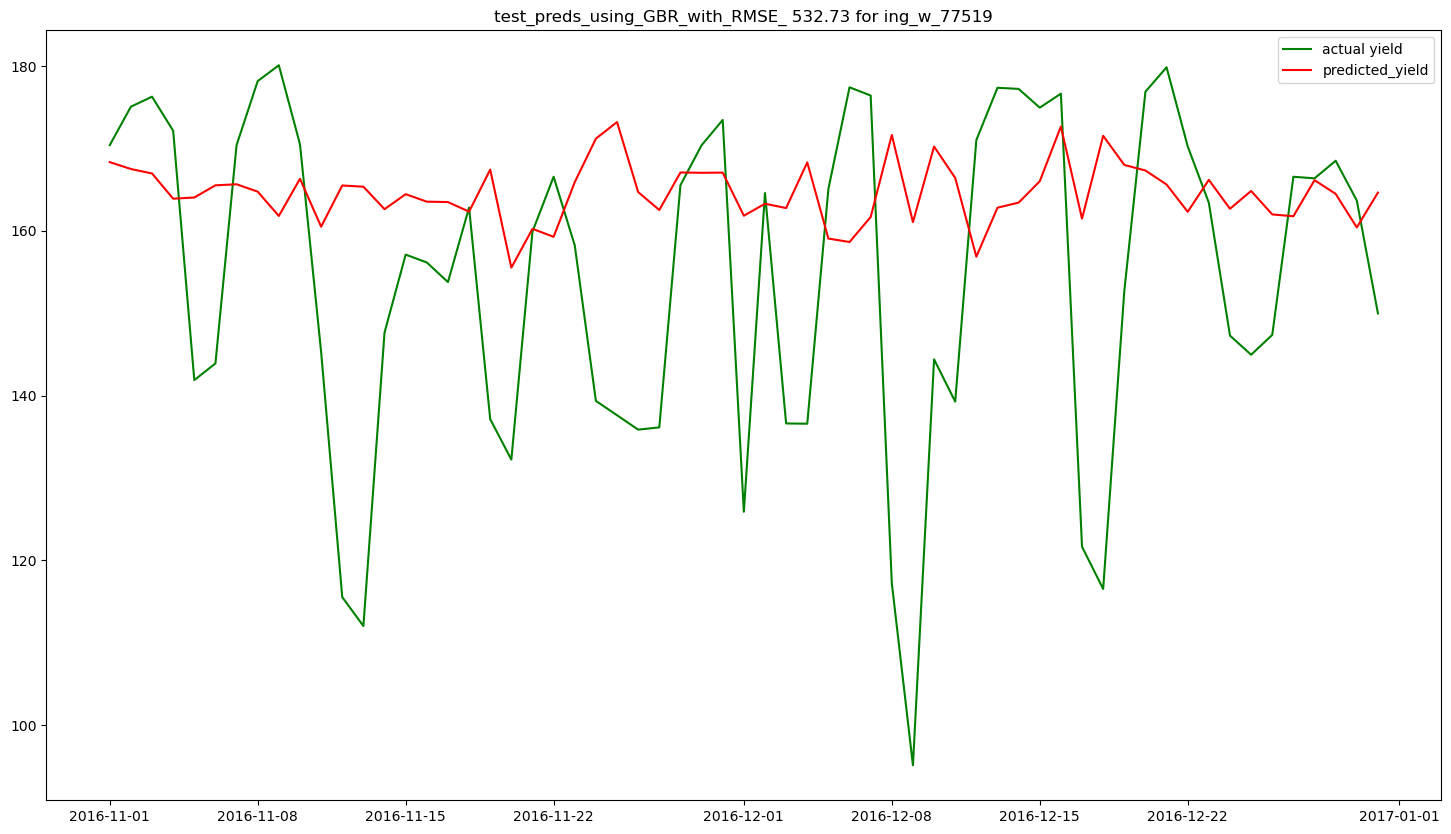

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr_day=GradientBoostingRegressor(n_estimators = 1000,criterion='mse')
gbr_day.fit(xtrd,ytrd)
test_preds_gbr_day=gbr_day.predict(xted)
print(mean_squared_error(yted,test_preds_gbr_day))
plt.figure(figsize=(18,10))
plt.plot(yted.index,yted['yield'],label='actual yield',color='green')
plt.plot(yted.index,test_preds_gbr_day,label='predicted_yield',color='red')
plt.title("test_preds_using_GBR_with_RMSE_ {:.2f} for ing_w_77519".format(float(mean_squared_error(yted['yield'],test_preds_gbr_day))))
plt.legend()
plt.show()

470.0566886397206


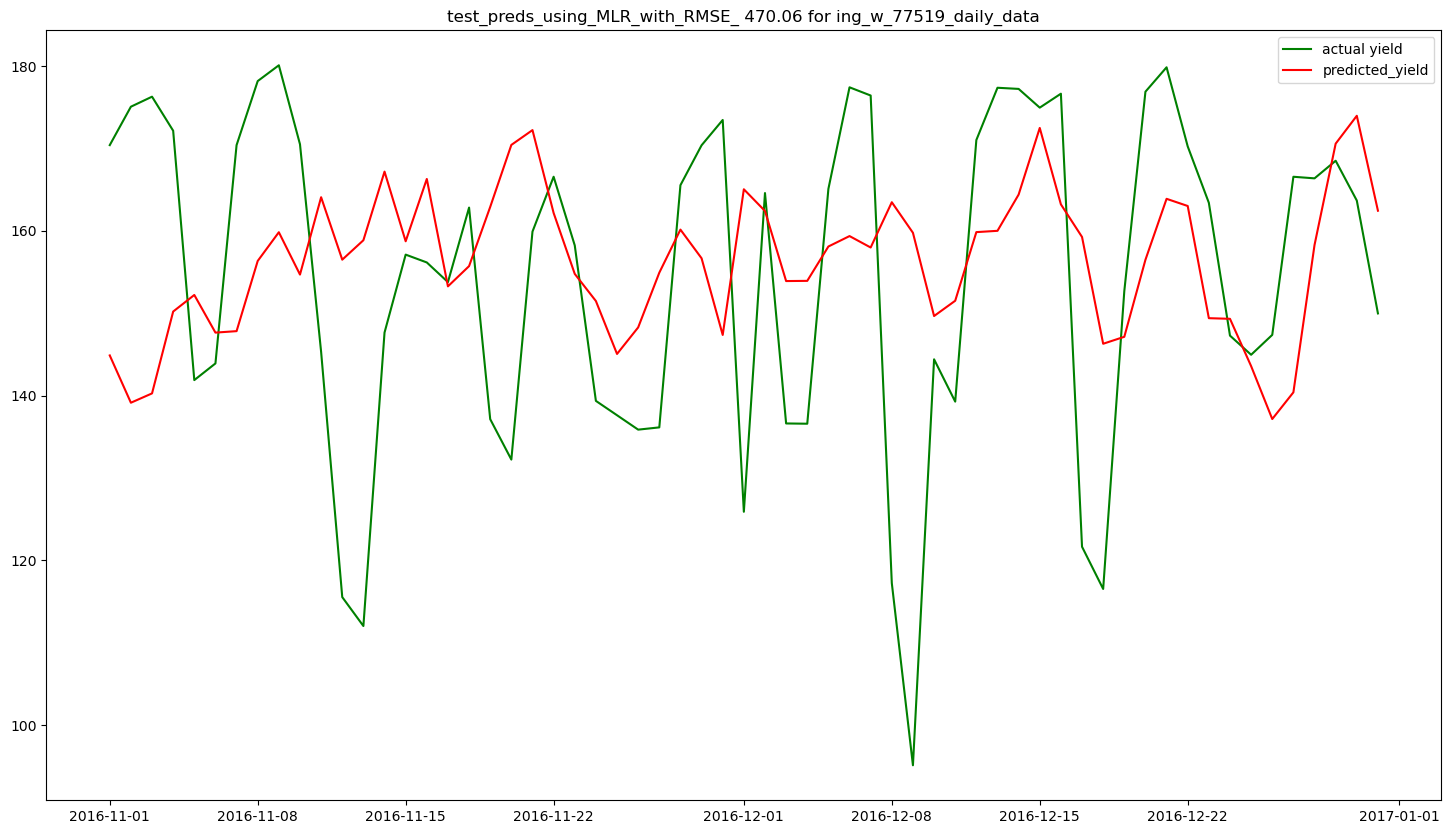

In [ ]:
# MLR
mlr_day=LinearRegression()
mlr_day.fit(xtrd,ytrd)
test_preds_mlr_day=mlr_day.predict(xted)
print(mean_squared_error(yted['yield'],test_preds_mlr_day))
plt.figure(figsize=(18,10))
plt.plot(yted.index,yted['yield'],label='actual yield',color='green')
plt.plot(yted.index,test_preds_mlr_day,label='predicted_yield',color='red')
plt.title("test_preds_using_MLR_with_RMSE_ {:.2f} for ing_w_77519_daily_data".format(float(mean_squared_error(yted['yield'],test_preds_mlr_day))))
plt.legend()
plt.show()

In [ ]:
# we have to predict the other farms data.? using this model?
# or all this process to be done for that data?

In [ ]:
# !pip install nbconvert